# FRE 6351 Econometircs and Time Series Final Project  
# Forecasting Sports Popularity

Yixin Xu, Zebei Wang, Qiwei Mo

#Introduction

The fascination with the NFL, NBA, and MLB extends beyond just the passionate fans; it holds significant value for advertisers and businesses invested in these leagues. The seasonal nature of these sports plays a pivotal role in shaping their popularity at different times of the year. To gauge the fluctuating interest in each league, we utilized search data from Google Trends. This source provides both real-time and historical insights into how often certain search terms are used, serving as a proxy for the leagues' popularity. Analyzing search volume allows us to not only understand which sports captivate public interest during their respective seasons but also predict future trends in their popularity. In our analysis, we explored and compared two univariate forecasting models—Holt-Winters Multiplicative Model and Seasonal Autoregressive Integrated Moving Average (SARIMA)—both theoretically and through practical application, to assess the popularity trends of these major sports leagues.

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset retreving and visualization

### 2.1 Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_nba = pd.read_csv('/content/drive/My Drive/6351_TimeSeries/NBA_popularity.csv', header=1, index_col='Month', parse_dates=True)
df_mlb = pd.read_csv('/content/drive/My Drive/6351_TimeSeries/MLB_popularity.csv', header=1, index_col='Month', parse_dates=True)
df_nfl = pd.read_csv('/content/drive/My Drive/6351_TimeSeries/NFL_popularity.csv', header=1, index_col='Month', parse_dates=True)

In [ ]:
# Join 3 datasets into one
df = pd.concat([df_nba,df_mlb,df_nfl], axis=1)

In [ ]:
df.head()

NBA: (United States)  MLB: (United States)  NFL: (United States)
Month                                                                       
2004-01-01                     8                     4                    13
2004-02-01                    10                     6                     8
2004-03-01                     7                     7                     6
2004-04-01                    10                    11                     9
2004-05-01                    12                    10                     3

The data represents the popularity of three major sports leagues in the United States—NBA (National Basketball Association), MLB (Major League Baseball), and NFL (National Football League)—over a series of months. Each number reflects the relative search volume or popularity of each sport during that particular month. The values are sourced from a tool like Google Trends, which quantifies interest in a topic based on the volume of search queries it receives.

In [ ]:
print(df.describe())

       NBA: (United States)  MLB: (United States)  NFL: (United States)
count            244.000000            244.000000            244.000000
mean              23.848361             29.418033             20.864754
std               19.127619             22.979089             18.782986
min                4.000000              4.000000              3.000000
25%                9.000000             11.000000              7.000000
50%               17.000000             21.000000             14.000000
75%               36.000000             41.000000             28.000000
max              100.000000            100.000000            100.000000


In [ ]:
# check for null
df.isnull().sum()

NBA: (United States)    0
MLB: (United States)    0
NFL: (United States)    0
dtype: int64

### 2.2 Data Visualization

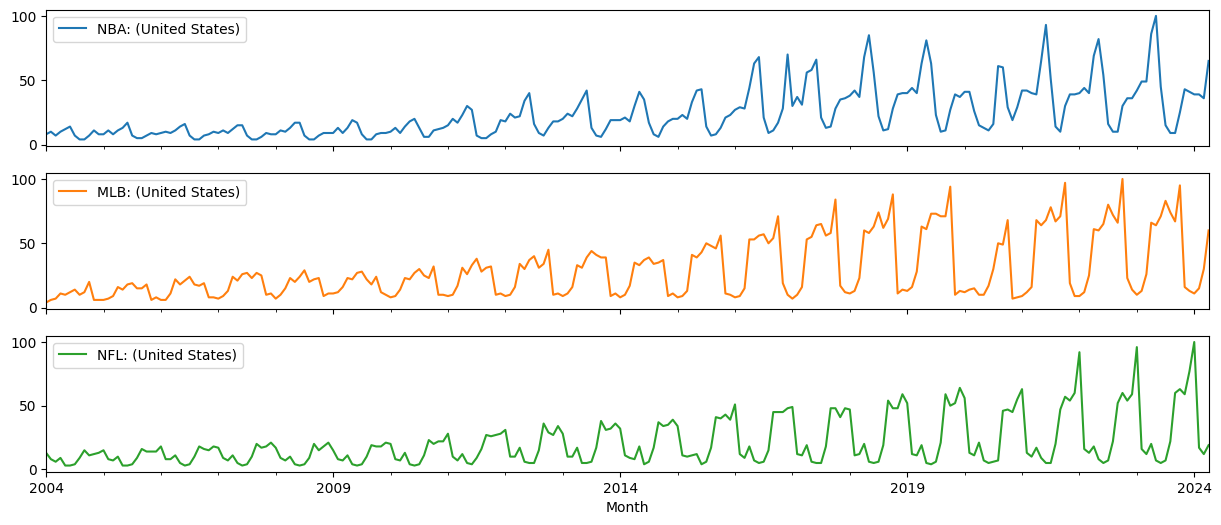

In [ ]:
df.plot(subplots=True, figsize=(15,6))
plt.show()

The plot displays the relative search volume trends for three major U.S. sports leagues—NBA, MLB, and NFL—from 2004 to 2024. Each graph represents the popularity of a league over time, plotted monthly.

The NBA shows a general upward trend with periodic peaks, likely corresponding to playoff and finals seasons.

MLB exhibits strong seasonality, with peaks every year around the start of its season in April and through the summer.

NFL popularity peaks sharply and annually, coinciding with the start of the season in September and increasing towards the Super Bowl in February.

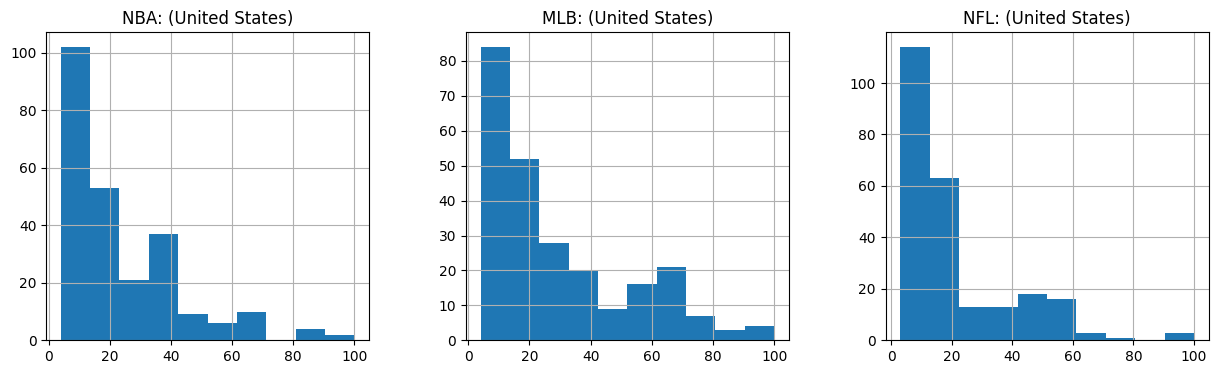

In [ ]:
df.hist(layout=(1,3),figsize=(15,4))
plt.show()

This set of histograms represents the distribution of search volume scores for the NBA, MLB, and NFL from 2004 to 2024. Each histogram shows how often certain levels of popularity (measured from 0 to 100) occur for each league.

For the NBA and NFL, the data skews towards higher values, indicating frequent high search volumes, likely during peak seasons and playoffs.

In contrast, the MLB histogram displays a more even spread but with a tendency towards higher frequencies at lower search volumes, suggesting a more consistent but less intense level of popularity throughout the season.

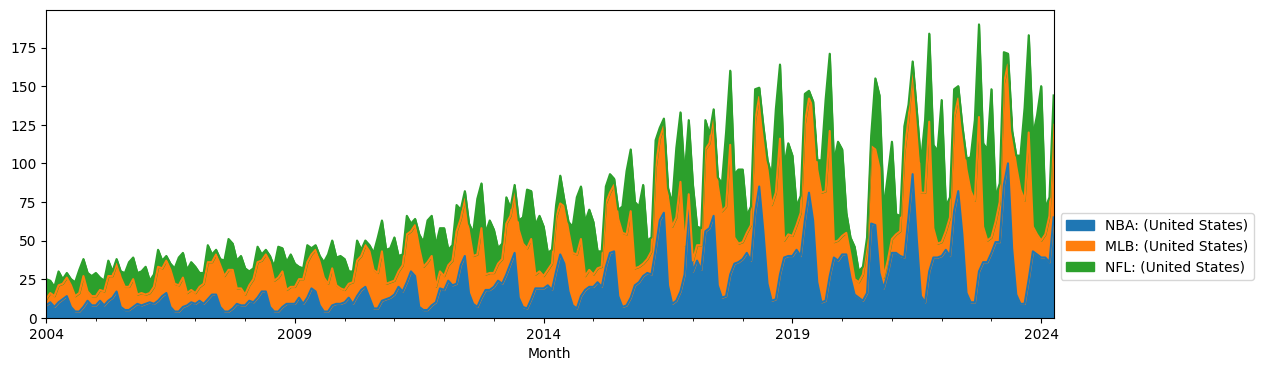

In [ ]:
ax=df.plot.area(figsize=(13,4))
ax.autoscale(axis='x',tight=True)
ax.legend(loc=3,bbox_to_anchor=(1.0,0.1))

This area plot illustrates the cumulative search volume trends for the NBA, MLB, and NFL from 2004 to 2024. The data is stacked, showing the combined popularity of all three leagues over time, with each league's contribution to the total shown in different colors—blue for the NBA, orange for MLB, and green for the NFL.
The graph highlights seasonal peaks in popularity that correspond to key periods in each sport's calendar, such as playoffs or championship games.

The NFL shows prominent spikes during its season, especially around the Super Bowl, while the NBA shows sustained interest during its season and playoffs. MLB's contributions remain relatively consistent, with a rise during the summer months, reflecting the regular baseball season.

## 3. EDA

### 3.1 Train Test Split

We first would like to prepare data for trend analysis.

 Initially, we applied a log transformation to the search volumes of each league. This transformation helps normalize the data, reduce the impact of outliers, and make the distribution more symmetric, which is particularly beneficial for modeling and analysis purposes.

In [ ]:
# log transformation
df['NBA_log'] = np.log(df['NBA: (United States)'])
df['MLB_log'] = np.log(df['MLB: (United States)'])
df['NFL_log'] = np.log(df['NFL: (United States)'])

Then we introduced a time variable t which serves as a sequential index starting from 1 and extending to the number of entries in the dataset. This variable is useful for analyzing trends over time in time series data.

In [ ]:
df['t'] = range(1,len(df)+1)

After that we extracted the month from each entry's date, assuming the dataframe's index is datetime-typed, and stored it in a new column called month. Following this, we created dummy variables for these months, transforming the categorical month data into a numerical format suitable for statistical modeling. This is achieved through one-hot encoding, which is then joined back to the main dataframe.

In [ ]:
df.loc[:,'month'] = df.index.month
month_dummies = pd.get_dummies(df.loc[:,'month'], prefix='month', dtype=int)
df = df.join(month_dummies)

Furthermore, we created a quadratic time variable t2 that is computed by squaring the time index t. This variable helps in capturing any nonlinear trends in the dataset, adding another layer of depth to the analysis.

In [ ]:
df.loc[:,'t2'] = df['t'] ** 2

In [ ]:
df

NBA: (United States)  MLB: (United States)  NFL: (United States)  \
Month                                                                          
2004-01-01                     8                     4                    13   
2004-02-01                    10                     6                     8   
2004-03-01                     7                     7                     6   
2004-04-01                    10                    11                     9   
2004-05-01                    12                    10                     3   
...                          ...                   ...                   ...   
2023-12-01                    41                    13                    77   
2024-01-01                    39                    11                   100   
2024-02-01                    39                    15                    17   
2024-03-01                    36                    30                    12   
2024-04-01                    65                    60                    19   

             NBA_log   MLB_log   NFL_log    t  month  month_1  month_2  ...  \
Month                                                                   ...   
2004-01-01  2.079442  1.386294  2.564949    1      1        1        0  ...   
2004-02-01  2.302585  1.791759  2.079442    2      2        0        1  ...   
2004-03-01  1.945910  1.945910  1.791759    3      3        0        0  ...   
2004-04-01  2.302585  2.397895  2.197225    4      4        0        0  ...   
2004-05-01  2.484907  2.302585  1.098612    5      5        0        0  ...   
...              ...       ...       ...  ...    ...      ...      ...  ...   
2023-12-01  3.713572  2.564949  4.343805  240     12        0        0  ...   
2024-01-01  3.663562  2.397895  4.605170  241      1        1        0  ...   
2024-02-01  3.663562  2.708050  2.833213  242      2        0        1  ...   
2024-03-01  3.583519  3.401197  2.484907  243      3        0        0  ...   
2024-04-01  4.174387  4.094345  2.944439  244      4        0        0  ...   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
Month                                                                        
2004-01-01        0        0        0        0        0        0         0   
2004-02-01        0        0        0        0        0        0         0   
2004-03-01        0        0        0        0        0        0         0   
2004-04-01        1        0        0        0        0        0         0   
2004-05-01        0        1        0        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2023-12-01        0        0        0        0        0        0         0   
2024-01-01        0        0        0        0        0        0         0   
2024-02-01        0        0        0        0        0        0         0   
2024-03-01        0        0        0        0        0        0         0   
2024-04-01        1        0        0        0        0        0         0   

            month_11  month_12     t2  
Month                                  
2004-01-01         0         0      1  
2004-02-01         0         0      4  
2004-03-01         0         0      9  
2004-04-01         0         0     16  
2004-05-01         0         0     25  
...              ...       ...    ...  
2023-12-01         0         1  57600  
2024-01-01         0         0  58081  
2024-02-01         0         0  58564  
2024-03-01         0         0  59049  
2024-04-01         0         0  59536  

[244 rows x 21 columns]

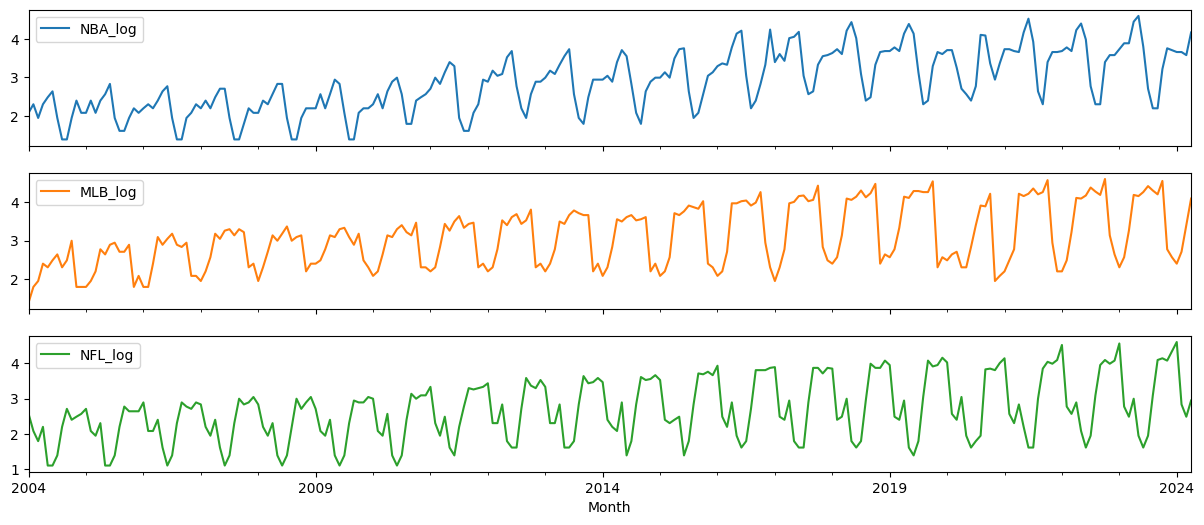

In [ ]:
df[['NBA_log','MLB_log','NFL_log']].plot(subplots=True, figsize=(15,6))
plt.show()

This set of line graphs displays the logarithmic search volume trends for the NBA, MLB, and NFL from 2004 to 2024, represented in separate subplots for clarity. The use of a logarithmic scale helps to stabilize variance and makes trends easier to interpret, particularly when there are exponential growth patterns or large fluctuations in data.

The NBA shows a gradual increasing trend over the years, indicating a steady rise in popularity.

The MLB graph exhibits a consistent seasonal pattern with peaks generally during its season months, reflecting the sport's annual cycle.

Meanwhile, the NFL graph also displays a clear seasonal pattern with sharp peaks each year, which likely correspond to the start of the NFL season and the build-up to the Super Bowl.

These trends highlight the periodic shifts in public interest relative to each sport's season and major events.

In [ ]:
df.head()

NBA: (United States)  MLB: (United States)  NFL: (United States)  \
Month                                                                          
2004-01-01                     8                     4                    13   
2004-02-01                    10                     6                     8   
2004-03-01                     7                     7                     6   
2004-04-01                    10                    11                     9   
2004-05-01                    12                    10                     3   

             NBA_log   MLB_log   NFL_log  t  month  month_1  month_2  ...  \
Month                                                                 ...   
2004-01-01  2.079442  1.386294  2.564949  1      1        1        0  ...   
2004-02-01  2.302585  1.791759  2.079442  2      2        0        1  ...   
2004-03-01  1.945910  1.945910  1.791759  3      3        0        0  ...   
2004-04-01  2.302585  2.397895  2.197225  4      4        0        0  ...   
2004-05-01  2.484907  2.302585  1.098612  5      5        0        0  ...   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
Month                                                                        
2004-01-01        0        0        0        0        0        0         0   
2004-02-01        0        0        0        0        0        0         0   
2004-03-01        0        0        0        0        0        0         0   
2004-04-01        1        0        0        0        0        0         0   
2004-05-01        0        1        0        0        0        0         0   

            month_11  month_12  t2  
Month                               
2004-01-01         0         0   1  
2004-02-01         0         0   4  
2004-03-01         0         0   9  
2004-04-01         0         0  16  
2004-05-01         0         0  25  

[5 rows x 21 columns]

In [ ]:
df.shape

(244, 21)

In [ ]:
df_train = df[0:208]
df_test = df[208:]

In [ ]:
df_train

NBA: (United States)  MLB: (United States)  NFL: (United States)  \
Month                                                                          
2004-01-01                     8                     4                    13   
2004-02-01                    10                     6                     8   
2004-03-01                     7                     7                     6   
2004-04-01                    10                    11                     9   
2004-05-01                    12                    10                     3   
...                          ...                   ...                   ...   
2020-12-01                    29                     8                    55   
2021-01-01                    42                     9                    63   
2021-02-01                    42                    12                    13   
2021-03-01                    40                    16                    10   
2021-04-01                    39                    68                    17   

             NBA_log   MLB_log   NFL_log    t  month  month_1  month_2  ...  \
Month                                                                   ...   
2004-01-01  2.079442  1.386294  2.564949    1      1        1        0  ...   
2004-02-01  2.302585  1.791759  2.079442    2      2        0        1  ...   
2004-03-01  1.945910  1.945910  1.791759    3      3        0        0  ...   
2004-04-01  2.302585  2.397895  2.197225    4      4        0        0  ...   
2004-05-01  2.484907  2.302585  1.098612    5      5        0        0  ...   
...              ...       ...       ...  ...    ...      ...      ...  ...   
2020-12-01  3.367296  2.079442  4.007333  204     12        0        0  ...   
2021-01-01  3.737670  2.197225  4.143135  205      1        1        0  ...   
2021-02-01  3.737670  2.484907  2.564949  206      2        0        1  ...   
2021-03-01  3.688879  2.772589  2.302585  207      3        0        0  ...   
2021-04-01  3.663562  4.219508  2.833213  208      4        0        0  ...   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
Month                                                                        
2004-01-01        0        0        0        0        0        0         0   
2004-02-01        0        0        0        0        0        0         0   
2004-03-01        0        0        0        0        0        0         0   
2004-04-01        1        0        0        0        0        0         0   
2004-05-01        0        1        0        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2020-12-01        0        0        0        0        0        0         0   
2021-01-01        0        0        0        0        0        0         0   
2021-02-01        0        0        0        0        0        0         0   
2021-03-01        0        0        0        0        0        0         0   
2021-04-01        1        0        0        0        0        0         0   

            month_11  month_12     t2  
Month                                  
2004-01-01         0         0      1  
2004-02-01         0         0      4  
2004-03-01         0         0      9  
2004-04-01         0         0     16  
2004-05-01         0         0     25  
...              ...       ...    ...  
2020-12-01         0         1  41616  
2021-01-01         0         0  42025  
2021-02-01         0         0  42436  
2021-03-01         0         0  42849  
2021-04-01         0         0  43264  

[208 rows x 21 columns]

In [ ]:
df_test

NBA: (United States)  MLB: (United States)  NFL: (United States)  \
Month                                                                          
2021-05-01                    65                    64                     9   
2021-06-01                    93                    68                     5   
2021-07-01                    51                    78                     5   
2021-08-01                    14                    67                    20   
2021-09-01                    10                    71                    47   
2021-10-01                    30                    97                    57   
2021-11-01                    39                    19                    54   
2021-12-01                    39                     9                    60   
2022-01-01                    40                     9                    92   
2022-02-01                    44                    12                    16   
2022-03-01                    40                    25                    13   
2022-04-01                    69                    61                    18   
2022-05-01                    82                    60                     8   
2022-06-01                    54                    65                     5   
2022-07-01                    16                    80                     7   
2022-08-01                    10                    72                    22   
2022-09-01                    10                    66                    52   
2022-10-01                    30                   100                    60   
2022-11-01                    36                    23                    54   
2022-12-01                    36                    14                    59   
2023-01-01                    42                    10                    96   
2023-02-01                    49                    13                    16   
2023-03-01                    49                    26                    12   
2023-04-01                    86                    66                    20   
2023-05-01                   100                    64                     7   
2023-06-01                    45                    71                     5   
2023-07-01                    15                    83                     7   
2023-08-01                     9                    74                    22   
2023-09-01                     9                    67                    60   
2023-10-01                    25                    95                    63   
2023-11-01                    43                    16                    59   
2023-12-01                    41                    13                    77   
2024-01-01                    39                    11                   100   
2024-02-01                    39                    15                    17   
2024-03-01                    36                    30                    12   
2024-04-01                    65                    60                    19   

             NBA_log   MLB_log   NFL_log    t  month  month_1  month_2  ...  \
Month                                                                   ...   
2021-05-01  4.174387  4.158883  2.197225  209      5        0        0  ...   
2021-06-01  4.532599  4.219508  1.609438  210      6        0        0  ...   
2021-07-01  3.931826  4.356709  1.609438  211      7        0        0  ...   
2021-08-01  2.639057  4.204693  2.995732  212      8        0        0  ...   
2021-09-01  2.302585  4.262680  3.850148  213      9        0        0  ...   
2021-10-01  3.401197  4.574711  4.043051  214     10        0        0  ...   
2021-11-01  3.663562  2.944439  3.988984  215     11        0        0  ...   
2021-12-01  3.663562  2.197225  4.094345  216     12        0        0  ...   
2022-01-01  3.688879  2.197225  4.521789  217      1        1        0  ...   
2022-02-01  3.784190  2.484907  2.772589  218      2        0        1  ...   
2022-03-01  3.688879  3

Now we try to change the data from 2020-03-01 to 2021-03-01 to the average value of 2018-03-01 to 2020-03-01 since there is covid during 2020-2021 and see how it would perform.

In [ ]:
df_adjusted = df_train.copy()

# Calculate the average values from March 2018 to March 2020 for each relevant column
average_values = df_adjusted.loc['2018-03-01':'2020-03-01'].groupby(df_adjusted.loc['2018-03-01':'2020-03-01'].index.month).mean()

# Now, apply these average values to the corresponding months from March 2020 to March 2021 in the new DataFrame
for date in pd.date_range('2020-03-01', '2021-03-01', freq='MS'):
    month = date.month
    if month in average_values.index:  # Check if the month is in the average_values index
        df_adjusted.loc[date] = average_values.loc[month]


In [ ]:
df_adjusted

NBA: (United States)  MLB: (United States)  NFL: (United States)  \
Month                                                                          
2004-01-01              8.000000                   4.0             13.000000   
2004-02-01             10.000000                   6.0              8.000000   
2004-03-01              7.000000                   7.0              6.000000   
2004-04-01             10.000000                  11.0              9.000000   
2004-05-01             12.000000                  10.0              3.000000   
...                          ...                   ...                   ...   
2020-12-01             38.500000                  13.5             61.500000   
2021-01-01             40.500000                  12.5             54.000000   
2021-02-01             42.500000                  15.0             12.500000   
2021-03-01             34.333333                  22.0             11.333333   
2021-04-01             39.000000                  68.0             17.000000   

             NBA_log   MLB_log   NFL_log    t  month  month_1  month_2  ...  \
Month                                                                   ...   
2004-01-01  2.079442  1.386294  2.564949    1      1        1        0  ...   
2004-02-01  2.302585  1.791759  2.079442    2      2        0        1  ...   
2004-03-01  1.945910  1.945910  1.791759    3      3        0        0  ...   
2004-04-01  2.302585  2.397895  2.197225    4      4        0        0  ...   
2004-05-01  2.484907  2.302585  1.098612    5      5        0        0  ...   
...              ...       ...       ...  ...    ...      ...      ...  ...   
2020-12-01  3.649899  2.602003  4.118210  186     12        0        0  ...   
2021-01-01  3.701226  2.524928  3.988298  187      1        1        0  ...   
2021-02-01  3.748881  2.705823  2.524928  188      2        0        1  ...   
2021-03-01  3.519298  3.058583  2.426899  183      3        0        0  ...   
2021-04-01  3.663562  4.219508  2.833213  208      4        0        0  ...   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
Month                                                                        
2004-01-01        0        0        0        0        0        0         0   
2004-02-01        0        0        0        0        0        0         0   
2004-03-01        0        0        0        0        0        0         0   
2004-04-01        1        0        0        0        0        0         0   
2004-05-01        0        1        0        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2020-12-01        0        0        0        0        0        0         0   
2021-01-01        0        0        0        0        0        0         0   
2021-02-01        0        0        0        0        0        0         0   
2021-03-01        0        0        0        0        0        0         0   
2021-04-01        1        0        0        0        0        0         0   

            month_11  month_12     t2  
Month                                  
2004-01-01         0         0      1  
2004-02-01         0         0      4  
2004-03-01         0         0      9  
2004-04-01         0         0     16  
2004-05-01         0         0     25  
...              ...       ...    ...  
2020-12-01         0         1  34632  
2021-01-01         0         0  35005  
2021-02-01         0         0  35380  
2021-03-01         0         0  33585  
2021-04-01         0         0  43264  

[208 rows x 21 columns]

NBA adjusted

<Axes: xlabel='Month'>

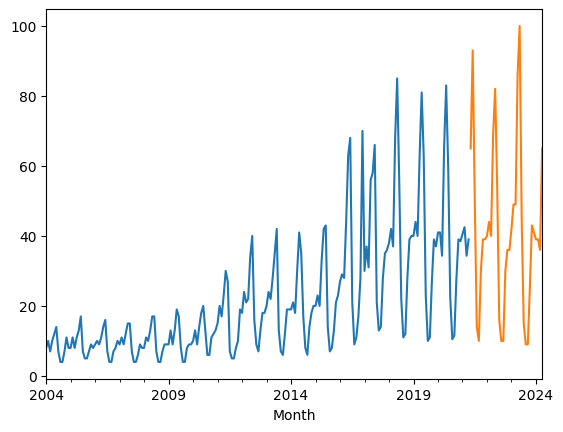

In [ ]:
df_adjusted['NBA: (United States)'].plot()
df_test['NBA: (United States)'].plot()

NBA

<Axes: xlabel='Month'>

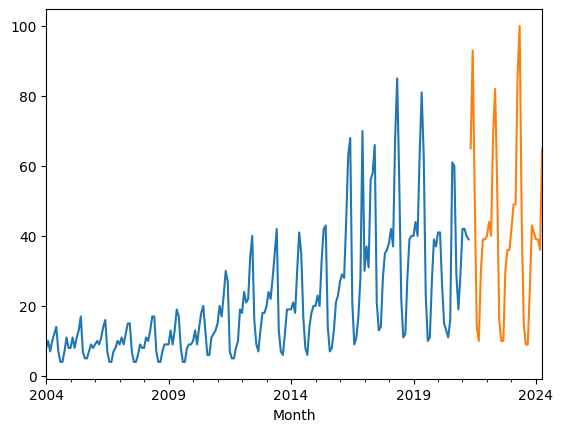

In [ ]:
df_train['NBA: (United States)'].plot()
df_test['NBA: (United States)'].plot()

MLB adjusted

<Axes: xlabel='Month'>

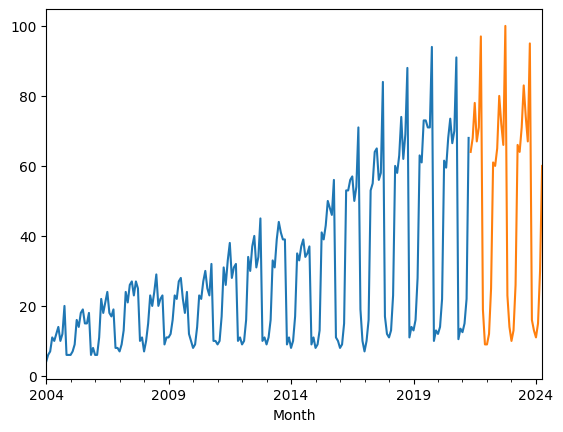

In [ ]:
df_adjusted['MLB: (United States)'].plot()
df_test['MLB: (United States)'].plot()

MLB

<Axes: xlabel='Month'>

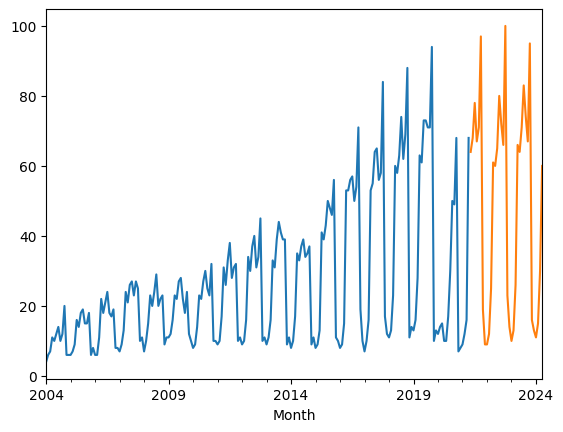

In [ ]:
df_train['MLB: (United States)'].plot()
df_test['MLB: (United States)'].plot()

NFL adjusted

<Axes: xlabel='Month'>

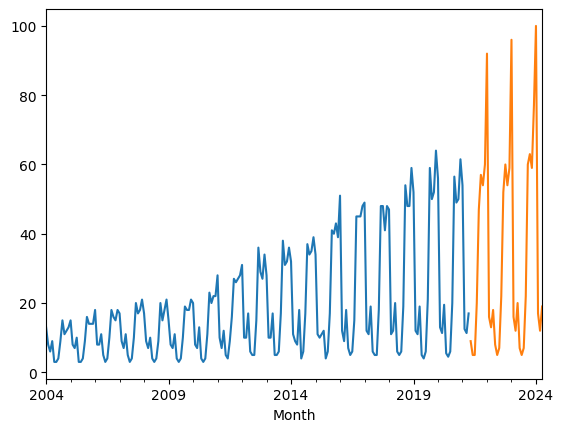

In [ ]:
df_adjusted['NFL: (United States)'].plot()
df_test['NFL: (United States)'].plot()

NFL

<Axes: xlabel='Month'>

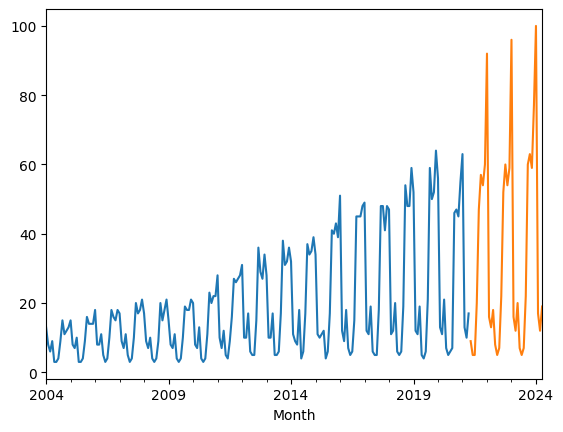

In [ ]:
df_train['NFL: (United States)'].plot()
df_test['NFL: (United States)'].plot()

### 3.2. Decomposition

Decomposing a time series is a crucial analysis technique to understand the underlying patterns such as trends, seasonality, and irregular components in the data. This method is particularly beneficial when dealing with data that exhibits periodic fluctuations over time, such as sports league popularity, which can be influenced by seasonal events (e.g., playoffs, championships) and long-term trends (increasing or decreasing interest over the years). By breaking down the time series into these fundamental components, we can better understand each's influence on the observed data, make more informed forecasting decisions, and potentially identify when anomalies occur.

In [ ]:
def decomp_plot(nba_decomp):
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,8))

    axes[0].plot(nba_decomp.observed, label='Observed')
    axes[0].set_title('Observed Data')
    axes[0].legend(loc='upper left')

    axes[1].plot(nba_decomp.trend, label='Trend', color='r')
    axes[1].set_title('Trend Component')
    axes[1].legend(loc='upper left')

    axes[2].plot(nba_decomp.seasonal, label='Seasonality', color='g')
    axes[2].set_title('Seasonal Component')
    axes[2].legend(loc='upper left')

    axes[3].plot(nba_decomp.resid, label='Residual', color='k')
    axes[3].set_title('Residual Component')
    axes[3].legend(loc='upper left')

    axes[3].set_xlabel('Date')
    plt.tight_layout()

    plt.show()

This decomp_plot function is designed to visually decompose a time series into its constituent components: observed data, trend, seasonality, and residuals.

NBA

In [ ]:
nba_decomp = seasonal_decompose(df_train['NBA_log'], model = 'additive')
nba_trend = nba_decomp.trend
nba_season = nba_decomp.seasonal
nba_resid = nba_decomp.resid

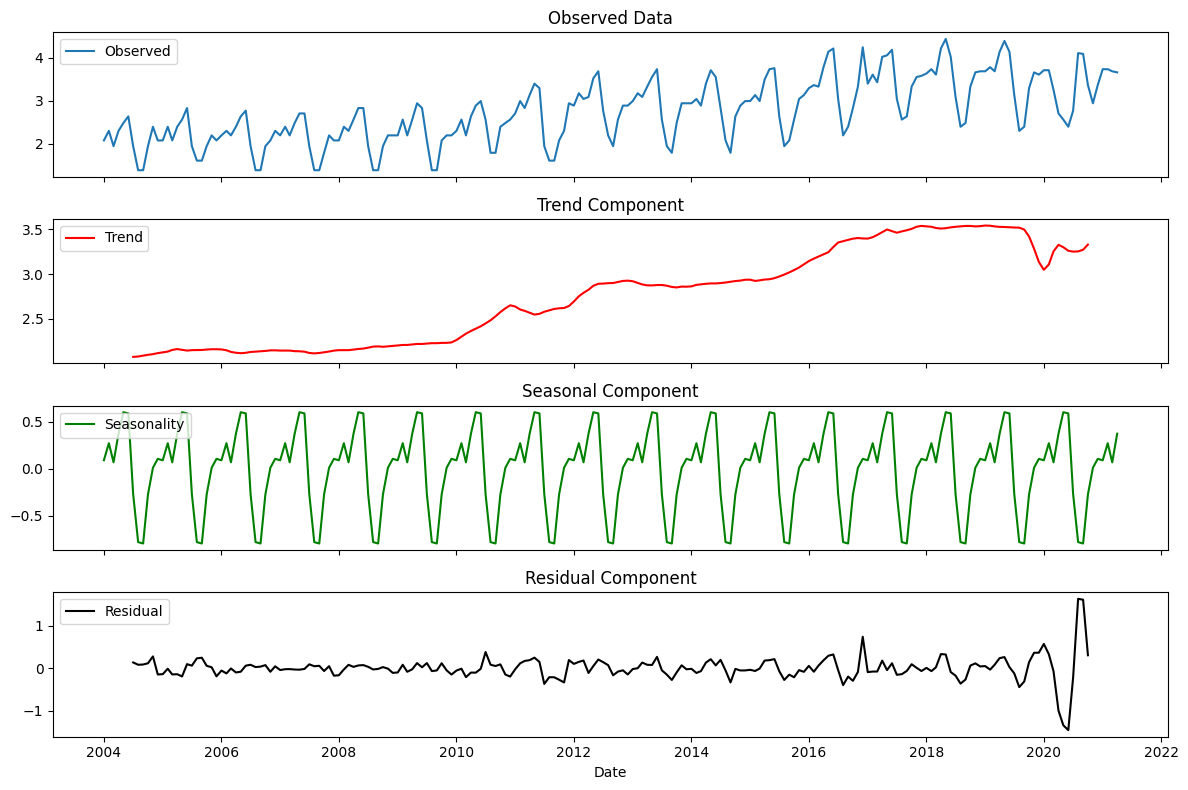

In [ ]:
decomp_plot(nba_decomp)

The Observed Data subplot shows the original logged search volumes, displaying regular fluctuations that suggest a combination of both seasonal patterns and other influences.

The Trend Component reveals a generally increasing trend in interest over time, suggesting growing popularity or increasing internet usage for searching NBA-related content. This trend appears to slightly dip towards the end of the period, indicating a potential plateau or slight decline in interest.

The Seasonal Component clearly shows strong, consistent seasonal fluctuations which repeat annually, aligning with the NBA season's start and peak during playoffs.

Finally, the Residual Component mostly hovers around zero but shows some variability, indicating minor unexplained variances by the model. A significant spike in residuals towards the end signals an anomaly or an event not captured by the trend or seasonal components, which could be a special event or abrupt change in the pattern of interest in the NBA, which is the Covid.

NBA adjusted

In [ ]:
nba_decomp_a = seasonal_decompose(df_adjusted['NBA_log'], model = 'additive')
nba_trend_a = nba_decomp_a.trend
nba_season_a = nba_decomp_a.seasonal
nba_resid_a = nba_decomp_a.resid

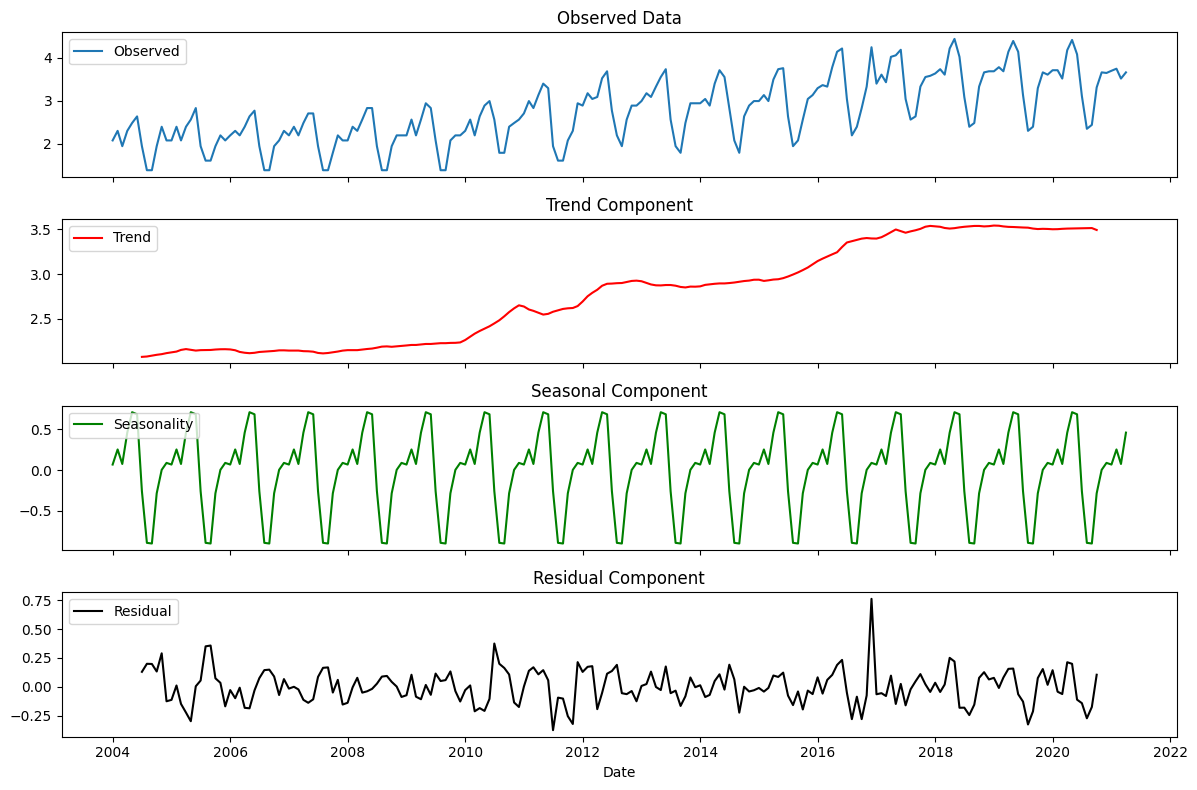

In [ ]:
decomp_plot(nba_decomp_a)

The main difference between the original and adjusted plots lies in how the observed data and trend components are represented around the 2020 period. The adjustment effectively normalizes the extreme variances caused by the pandemic, providing a hypothetical view of continued interest and growth in the NBA without external disruptions. This adjustment helps in analyzing long-term trends more effectively by filtering out the noise introduced by unprecedented events such as the pandemic.

MLB

In [ ]:
mlb_decomp = seasonal_decompose(df_train['MLB_log'], model = 'additive')
mlb_trend = mlb_decomp.trend
mlb_season = mlb_decomp.seasonal
mlb_resid = mlb_decomp.resid

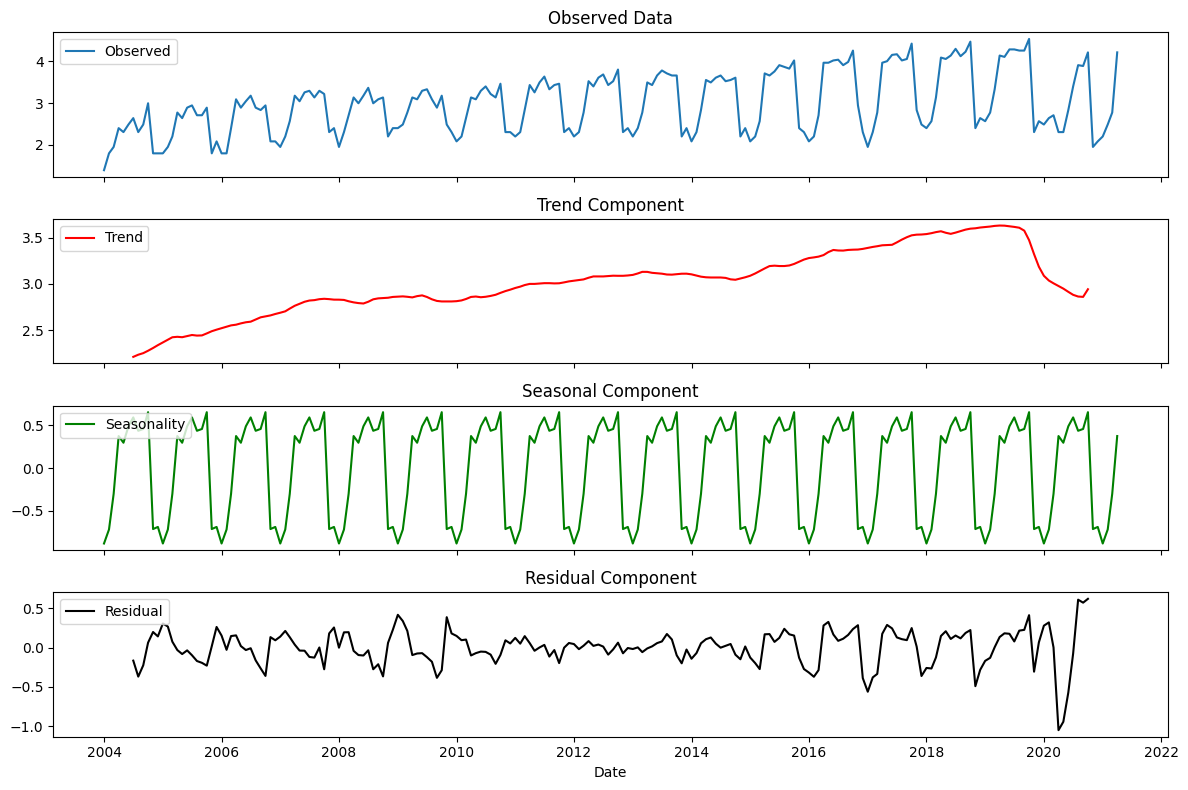

In [ ]:
decomp_plot(mlb_decomp)

The Observed Data shows the actual logged search volumes, which exhibit clear cyclical patterns corresponding to seasonal interest in MLB, particularly increasing around the start and throughout the baseball season.

The Trend Component reveals a gentle upward trend until around 2017, after which it begins a slight decline, suggesting a peak and subsequent gradual drop in interest over the years.

The Seasonal Component highlights very pronounced and consistent seasonal fluctuations that align with the annual MLB season, indicating predictable spikes in public interest during specific times of the year.

The Residual Component shows the noise or irregularities not explained by the trend or seasonal components, with relatively small variations except for a significant spike at the end of the period, possibly indicating an unexpected event or anomaly not captured by the other components.

MLB adjusted

In [ ]:
mlb_decomp_a = seasonal_decompose(df_adjusted['MLB_log'], model = 'additive')
mlb_trend_a = mlb_decomp_a.trend
mlb_season_a = mlb_decomp_a.seasonal
mlb_resid_a = mlb_decomp_a.resid

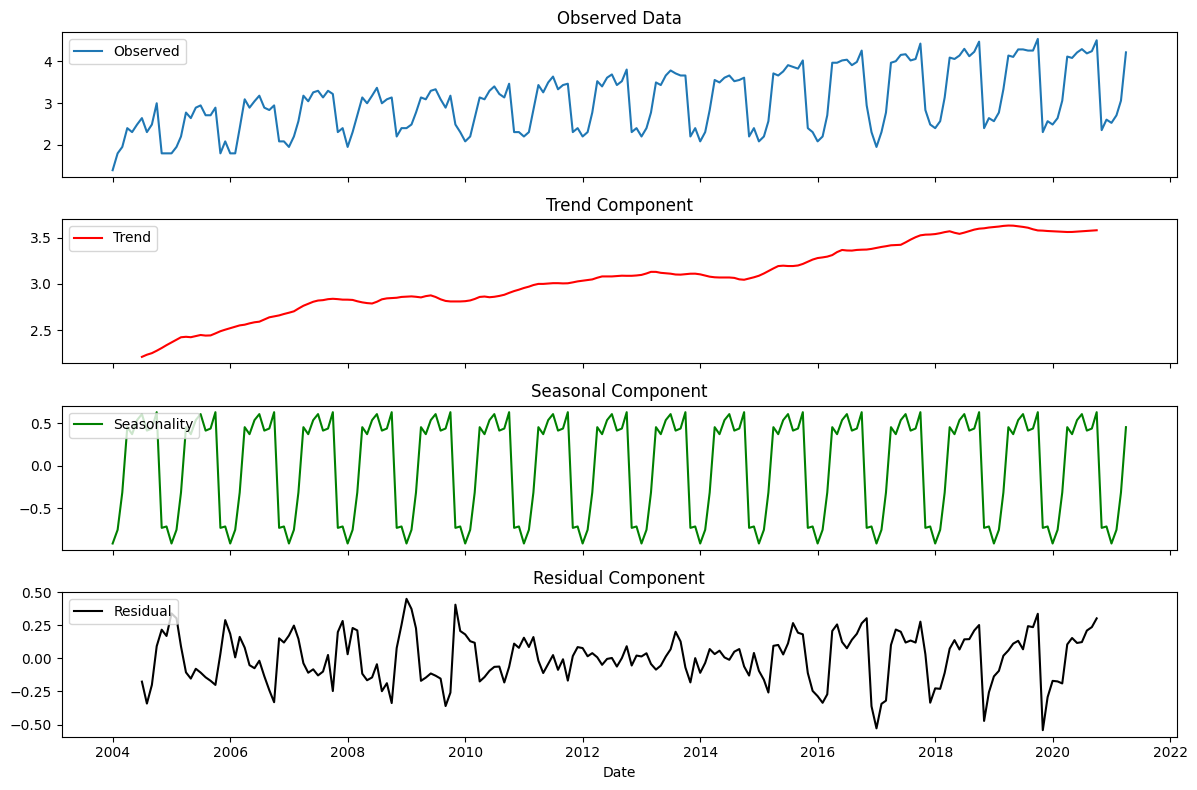

In [ ]:
decomp_plot(mlb_decomp_a)

Adjusting the MLB data from March 2020 to March 2021 to reflect average values from previous years effectively smooths out the abrupt changes caused by the pandemic. This adjustment helps stakeholders visualize what the MLB's popularity trajectory might have looked like without the interruption of COVID-19. By stabilizing these figures, analysts can better predict future trends and make informed decisions without the skew of unprecedented, non-recurring events. The adjustment makes the data more useful for understanding long-term trends and preparing for future seasons under normal conditions

NFL

In [ ]:
nfl_decomp = seasonal_decompose(df_train['NFL_log'], model = 'additive')
nfl_trend = nfl_decomp.trend
nfl_season = nfl_decomp.seasonal
nfl_resid = nfl_decomp.resid

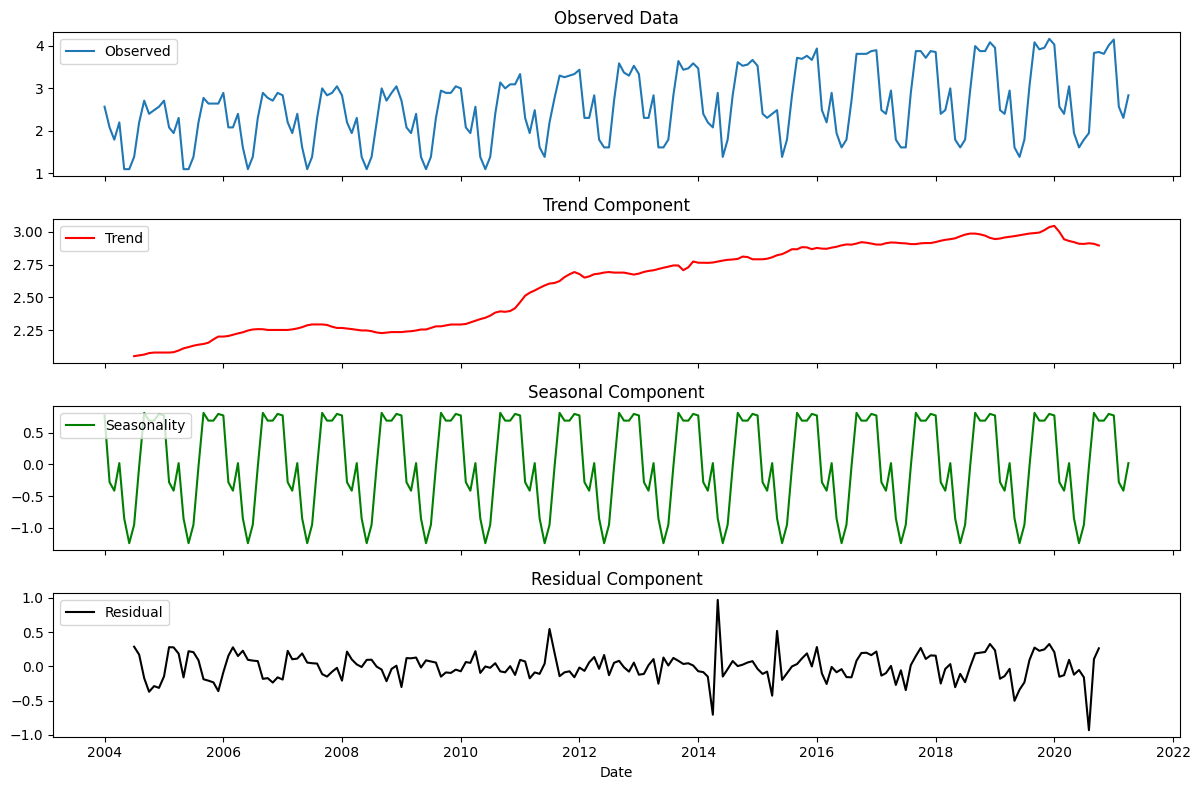

In [ ]:
decomp_plot(nfl_decomp)

The Observed Data shows the actual logged search volumes, demonstrating notable seasonal peaks that likely correspond to the NFL season and playoffs.

The Trend Component displays a slightly upward trajectory, indicating a gradual increase in interest over the years, with a particularly stable increase from around 2012 onward.

The Seasonal Component strongly highlights the NFL's annual seasonal pattern, with sharp spikes in interest reflecting the start of the season, playoffs, and the Super Bowl.

The Residual Component fluctuates around zero with some irregularities, but notably increases in variability toward the end of the period, suggesting unexplained variations or external influences on search volume that are not captured by the trend or seasonal components. This might include unusual events or changes within the league that temporarily affected public interest.

NFL adjusted

In [ ]:
nfl_decomp_a = seasonal_decompose(df_adjusted['NFL_log'], model = 'additive')
nfl_trend_a = nfl_decomp_a.trend
nfl_season_a = nfl_decomp_a.seasonal
nfl_resid_a = nfl_decomp_a.resid

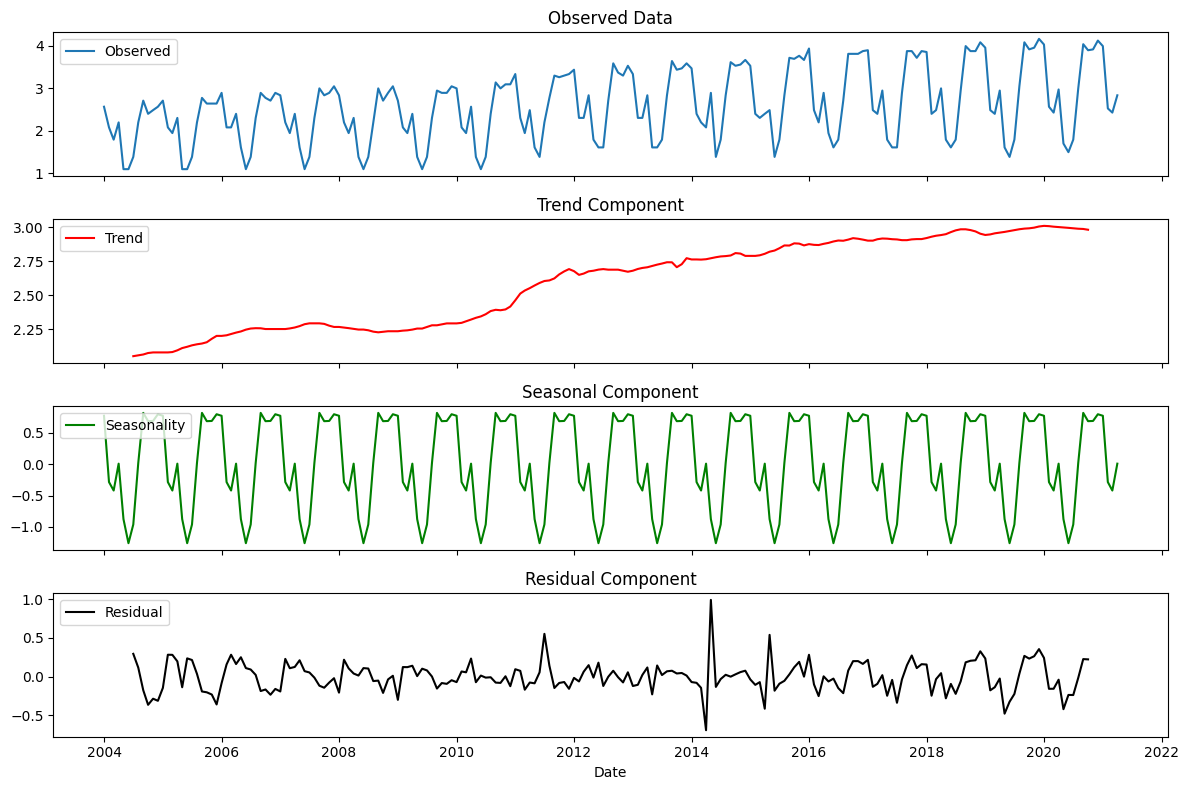

In [ ]:
decomp_plot(nfl_decomp_a)

The adjustment essentially 'normalizes' the NFL data for 2020, removing the stark impact of the pandemic observed initially. This results in a visualization that might better represent underlying trends and seasonal behaviors without the noise of the pandemic. Such adjustments are crucial for analyses aiming to predict future trends under 'normal' conditions or when trying to assess the long-term impact of the pandemic relative to an uninterrupted scenario. This method allows stakeholders to better isolate the effects of the pandemic from the inherent trends and seasonality of the NFL's popularity.

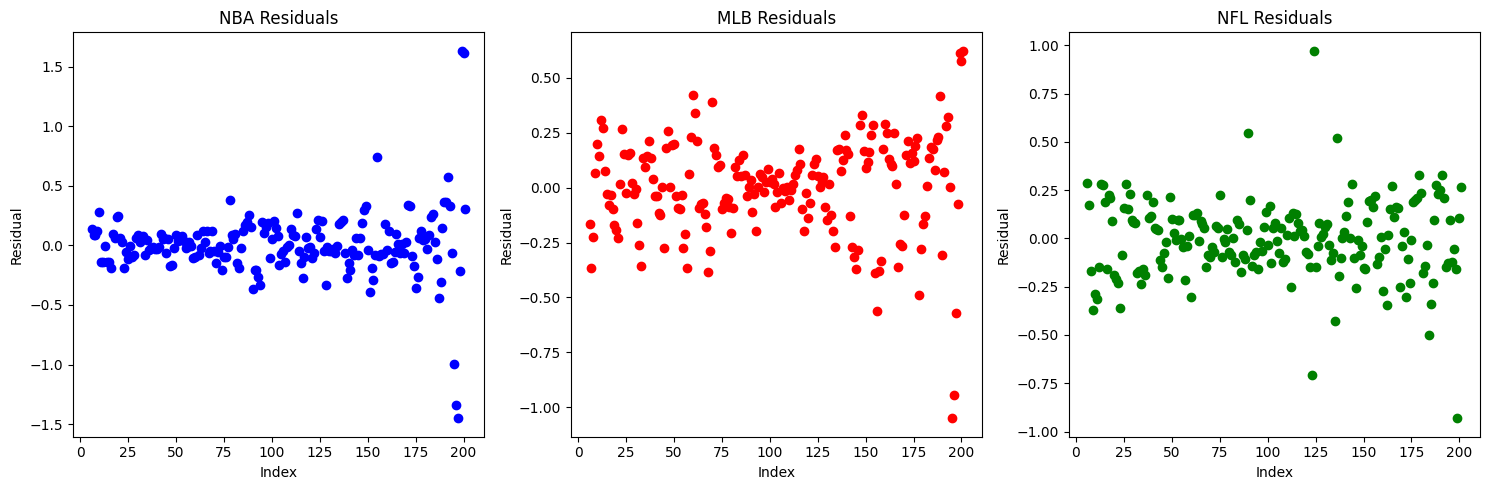

In [ ]:
# plot residuals before adjustment
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

axes[0].scatter(range(len(nba_resid)), nba_resid, color='blue')
axes[0].set_title('NBA Residuals')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Residual')

axes[1].scatter(range(len(mlb_resid)), mlb_resid, color='red')
axes[1].set_title('MLB Residuals')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Residual')

axes[2].scatter(range(len(nfl_resid)), nfl_resid, color='green')
axes[2].set_title('NFL Residuals')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Residual')

plt.tight_layout()

plt.show()

check for stationarity for each residuals

In [ ]:
def adftest(data_set, maxlag=None):

    data_set = data_set.replace([np.inf, -np.inf], np.nan).dropna()

    result = adfuller(data_set, maxlag=maxlag, autolag=None)

    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    print('Augmented Dickey-Fuller Test:')

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis. Time series is non-stationary.")


In [ ]:
def plot_cf(data, lags=20, acf=True, pacf=True):

    assert acf or pacf

    if acf:
      fig = plot_acf(data.dropna(), lags=lags, zero=False)
      fig.set_size_inches(12,3)

    if pacf:
      fig = plot_pacf(data.dropna(), lags=lags, method="ldb", zero=False)
      fig.set_size_inches(12,3)

In [ ]:
def stationaryplot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()

    plt.figure(figsize=(12,5))
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')

    plt.xlabel('Time in Years')t
    plt.ylabel('Total Emissions')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block= True)

NBA

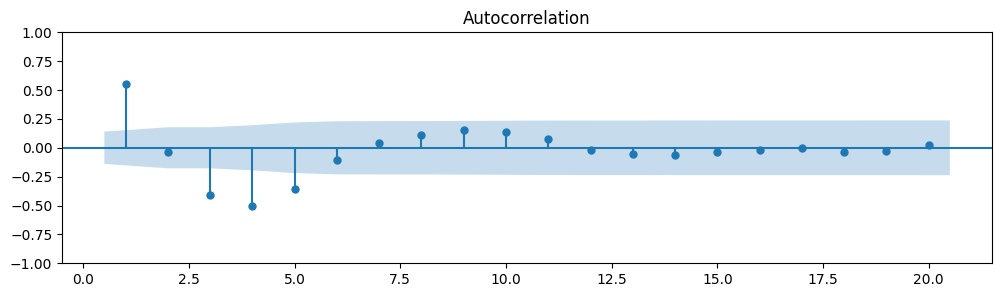

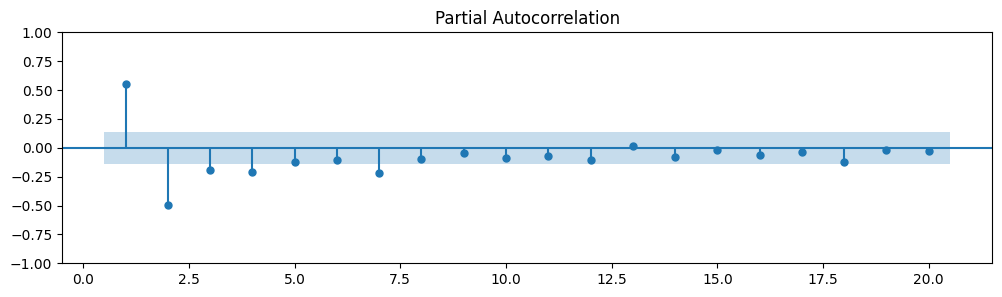

In [ ]:
plot_cf(nba_resid)

In [ ]:
adftest(nba_resid)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.3202314207143555
p-value : 0.0004097108390712684
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


NBA adjusted

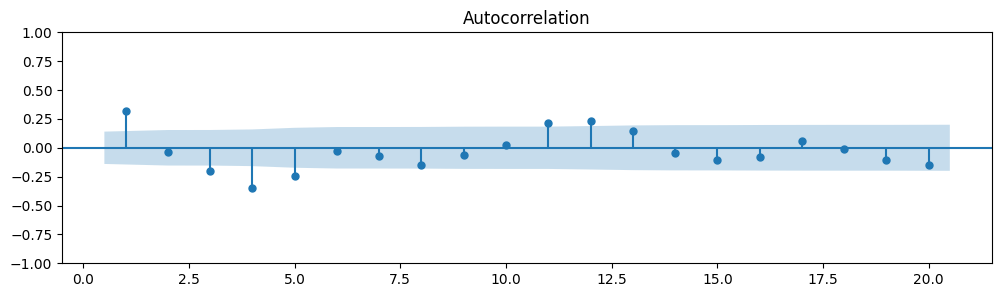

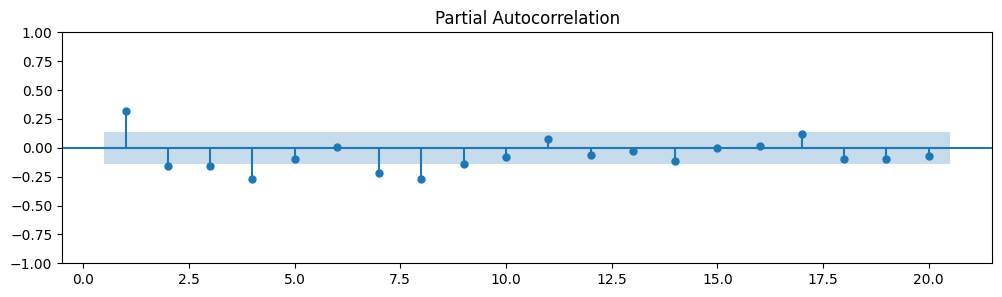

In [ ]:
plot_cf(nba_resid_a)

In [ ]:
adftest(nba_resid_a)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.584834209899109
p-value : 1.3704471296256204e-06
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


Adjusting the NBA data to normalize for the pandemic period has slightly smoothed the ACF, reducing some of the noise or variability that might have been caused by the abrupt changes during the pandemic. This suggests that the adjustment may help in yielding a cleaner signal for modeling purposes, focusing on the inherent properties of the data without the temporary disruptions. The PACF's stability post-adjustment reinforces the idea that the NBA time series can effectively be modeled with simpler autoregressive processes, primarily relying on recent past data.

The improvement in the ADF test statistic and the reduction in the p-value in the adjusted data set suggest that the normalization of the data to account for the pandemic period has enhanced the series' overall stationarity. By averaging out the volatile period of 2020-2021 with data from previous years, the adjustments likely removed some irregular fluctuations and anomalies caused by the pandemic's unique circumstances. This not only simplifies modeling efforts but also potentially increases the reliability of any statistical or econometric analyses conducted on the data. The enhanced stationarity underscores that the adjustments have likely created a smoother, more consistent time series, reducing transient spikes and drops that might have skewed analyses focused on the underlying trends and cycles in NBA popularity.

MLB

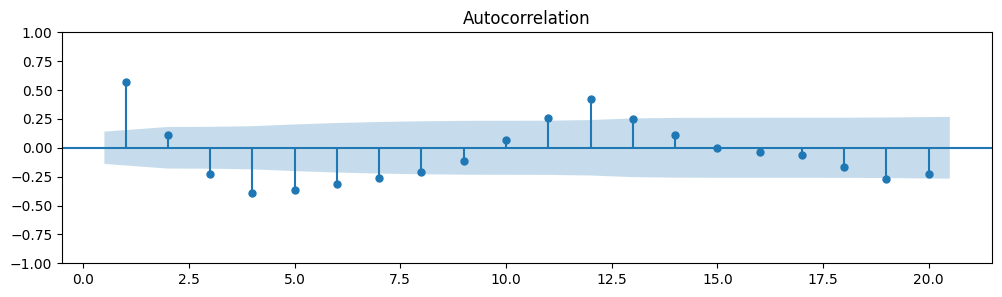

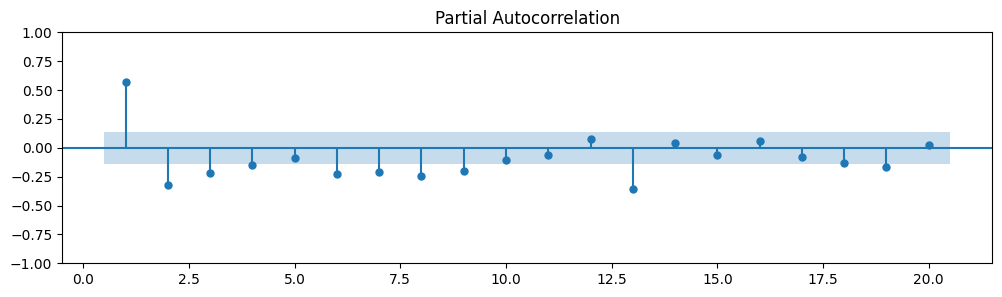

In [ ]:
plot_cf(mlb_resid)

In [ ]:
adftest(mlb_resid)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.565074313740233
p-value : 1.5111963696067207e-06
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


MLB adjusted

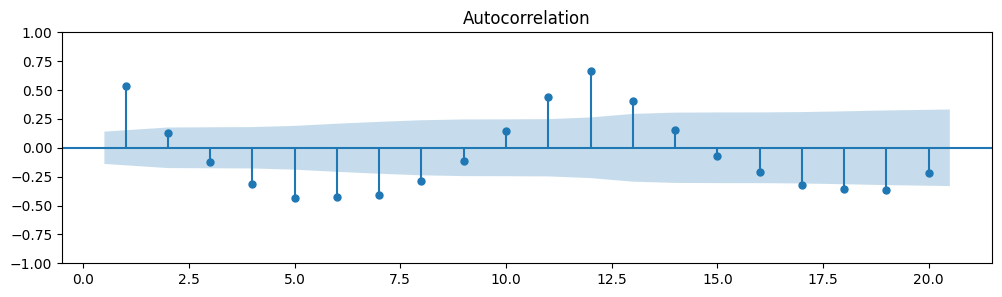

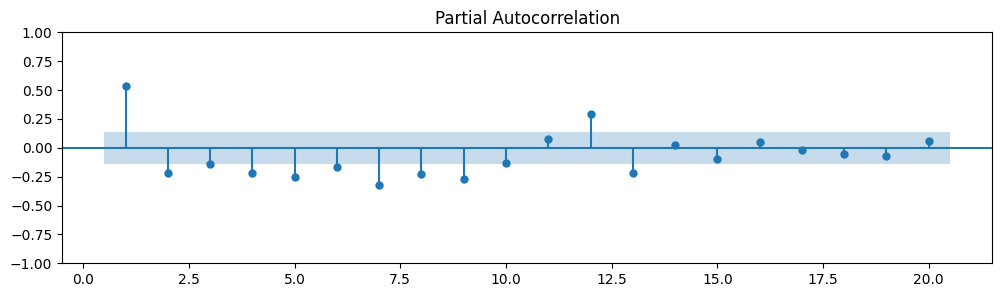

In [ ]:
plot_cf(mlb_resid_a)

In [ ]:
adftest(mlb_resid_a)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.990541543289351
p-value : 1.749933068542595e-07
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


Adjusting the MLB data to replace values from March 2020 to March 2021 with average values from the previous years has a subtle effect on the ACF and PACF. The essential characteristics of the data remain intact, indicating that the adjustment was successful in normalizing for extraordinary events without distorting the series' inherent properties.

The primary benefit of such adjustments is clearer in the ACF plot, where reduced spikes at higher lags post-adjustment suggest reduced noise or variability, potentially making future forecasts more reliable and less sensitive to the irregular impacts of the pandemic. This stabilization helps in maintaining focus on the underlying patterns of MLB popularity, aiding in more accurate and predictive modeling efforts.

The comparison between the pre-adjusted and post-adjusted ADF test results for MLB highlights a noticeable improvement in the indicators of stationarity. The decrease in both the ADF statistic and p-value in the adjusted data suggests that the normalization of the pandemic-affected periods has likely mitigated any atypical variances or anomalies. Such adjustment ensures that the data reflects a more typical operational scenario, devoid of the extreme disruptions that occurred during the pandemic.

NFL

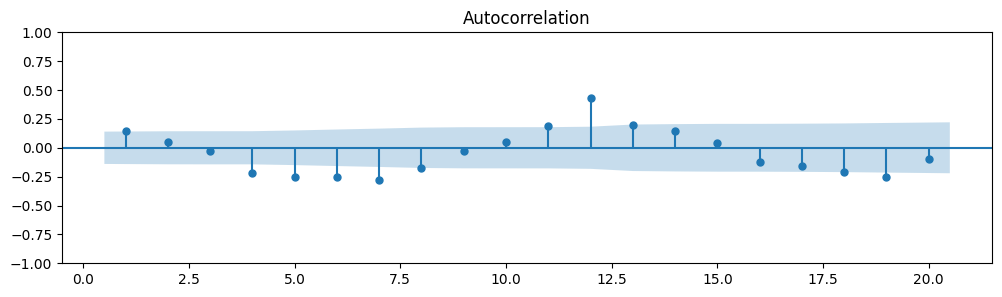

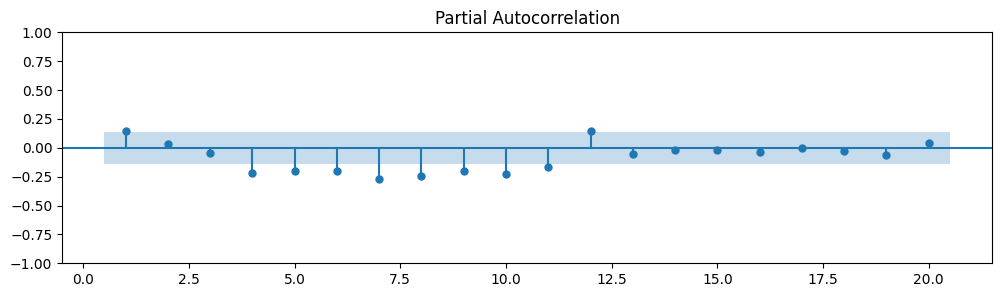

In [ ]:
plot_cf(nfl_resid)

In [ ]:
adftest(nfl_resid)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.75680779816274
p-value : 2.8580044541376666e-09
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


NFL adjusted

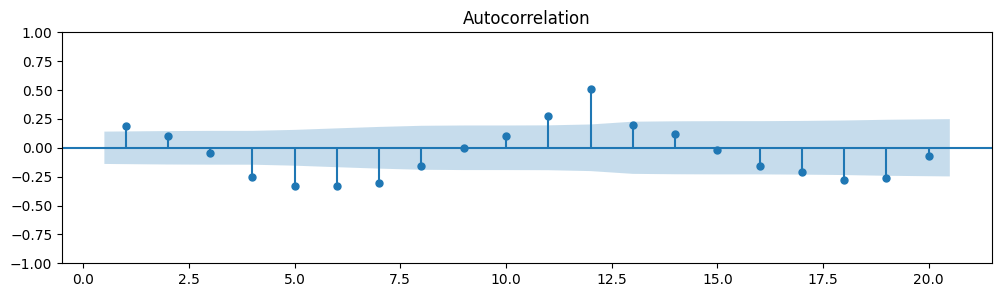

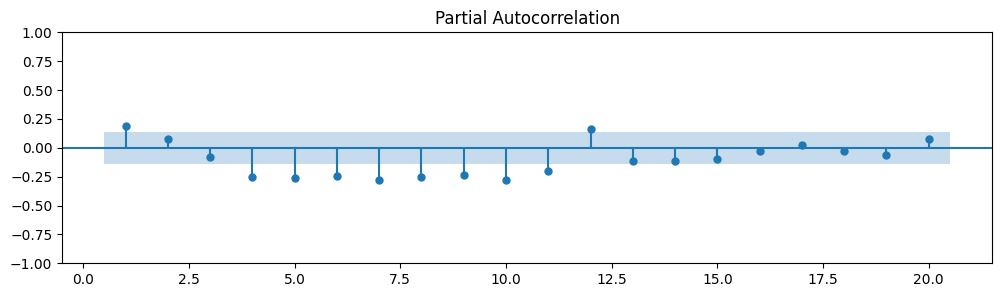

In [ ]:
plot_cf(nfl_resid_a)

In [ ]:
adftest(nfl_resid_a)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.664236071994328
p-value : 4.762069743522217e-09
#Lags Used : 15
Number of Observations Used : 180
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


The adjustment made to the NFL data clearly affects the autocorrelation structure, particularly by reducing the number of significant spikes throughout the series, leading to a cleaner and potentially more interpretable ACF. This could be particularly beneficial for modeling purposes, as it simplifies the underlying process by removing extraneous noise and emphasizing more systematic patterns.

The persistence of the initial strong autocorrelation in both plots underscores the continued influence of immediate past values on the current values, a common characteristic in sports-related time series data where recent performances or seasons affect subsequent outcomes.

The reduction in random spikes post-adjustment could also indicate that the data now better represents the inherent cyclical nature of the NFL without being overshadowed by the sporadic impacts of external disruptions like those experienced during the pandemic.

The slight decrease in the ADF statistic in the adjusted data compared to the original data suggests a minimal impact from averaging out the pandemic-affected period with values from preceding years. This minimal change indicates that the original data’s stationarity was not heavily influenced by the irregularities of the pandemic period, or that the method used for adjustment was effective in maintaining the inherent properties of the time series.

Both p-values remain exceedingly low in both the original and adjusted tests, maintaining robust support for the stationarity of the series across both versions of the data. This consistency is crucial as it suggests that the fundamental characteristics of the data that inform predictions and analyses remain intact, even after adjustments.

According to the ACF and PACF plot and the ADF test, the residual is stationary under seasonal decomposition method of python.  


### 3.3 Moving Average

In [ ]:
moving_avg = df_train.rolling(12).mean()

In [ ]:
ma_diff = df_train-moving_avg

In [ ]:
ma_diff.dropna(inplace=True)

NBA

In [ ]:
adftest(ma_diff['NBA_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.1060032725281017
p-value : 0.026112097547927572
#Lags Used : 15
Number of Observations Used : 181
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


NBA adjusted

In [ ]:
moving_avg_a = df_adjusted.rolling(12).mean()
ma_diff_a = df_adjusted-moving_avg_a
ma_diff_a.dropna(inplace=True)

In [ ]:
adftest(ma_diff_a['NBA_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0348494052390684
p-value : 0.0317655988023088
#Lags Used : 15
Number of Observations Used : 181
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


The slight increase in the ADF statistic (closer to zero) and the corresponding p-value in the adjusted data compared to the original data after applying the moving average correction suggests a slight decrease in the strength of stationarity. This could be due to the normalization of the data during the pandemic period, which might have slightly altered the intrinsic dynamics of the dataset, though not enough to affect its overall stationarity classification.

Both datasets, however, still comfortably meet the criteria for stationarity post-moving average application, confirming that both the original and adjusted datasets are suitable for further time series analysis and modeling without concerns over non-stationarity due to trends.

MLB

In [ ]:
adftest(ma_diff['MLB_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.258537043970986
p-value : 0.0005236721997561737
#Lags Used : 15
Number of Observations Used : 181
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


MLB adjusted

In [ ]:
adftest(ma_diff_a['MLB_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0085946240181474
p-value : 0.03409952875290513
#Lags Used : 15
Number of Observations Used : 181
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


The comparison between the two tests shows a notable decrease in the strength of the stationarity in the adjusted data. The original dataset's ADF statistic and p-value provide stronger evidence for rejecting the null hypothesis compared to the adjusted dataset. This could suggest that the process of normalizing the data by replacing pandemic-impacted observations with historical averages slightly weakened the inherent stability or uniformity of the dataset.

Despite this, both datasets still qualify as stationary, which means that for both the original and adjusted data, the influence of time-based trends or seasonality has been effectively neutralized by the moving average subtraction. This stationarity is crucial for any further analyses, ensuring that models or forecasts developed from this data are based on stable, consistent historical patterns without the influence of potentially misleading trends.

NFL

In [ ]:
adftest(ma_diff['NFL_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.2495244446435843
p-value : 0.1887641307649014
#Lags Used : 15
Number of Observations Used : 181
Weak evidence against null hypothesis. Time series is non-stationary.


NFL adjusted

In [ ]:
adftest(ma_diff_a['NFL_log'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.4819633611582463
p-value : 0.1199247364058062
#Lags Used : 15
Number of Observations Used : 181
Weak evidence against null hypothesis. Time series is non-stationary.


Comparing the two ADF test results shows a slight improvement in the stationarity of the NFL data after the adjustments made for the pandemic period. This improvement is visible in both the ADF statistic (becoming more negative) and the p-value (decreasing), suggesting that the normalization of the data may have slightly reduced some of the time-dependent structures or irregularities.

However, both the original and adjusted datasets still exhibit non-stationarity according to the ADF test results. This indicates that further modifications, such as differencing or more complex detrending methods, might be necessary to achieve stationarity. Non-stationarity in these datasets could be due to deeper structural factors, such as underlying trends not fully removed by the moving average or other inherent properties of the data like volatility clustering.


### 3.4 Exponential Smoothing

Original

In [ ]:
nba_expsmth = ExponentialSmoothing(df_train['NBA_log']-nba_season,freq='MS').fit(smoothing_level=0.2).fittedvalues
mlb_expsmth = ExponentialSmoothing(df_train['MLB_log']-mlb_season,freq='MS').fit(smoothing_level=0.2).fittedvalues
nfl_expsmth = ExponentialSmoothing(df_train['NFL_log']-nfl_season,freq='MS').fit(smoothing_level=0.2).fittedvalues

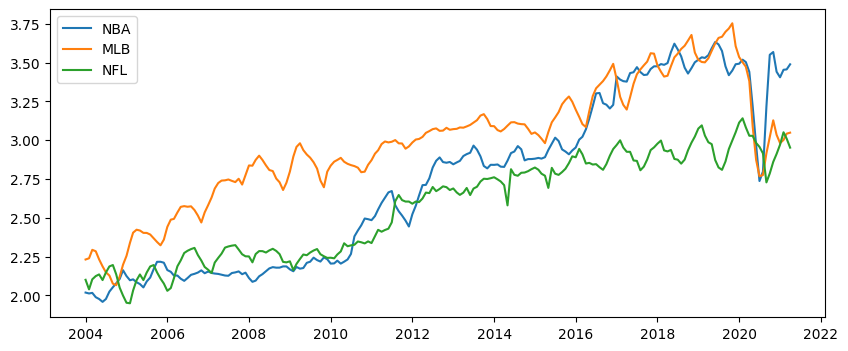

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(nba_expsmth, label='NBA')
plt.plot(mlb_expsmth, label='MLB')
plt.plot(nfl_expsmth, label='NFL')
plt.legend()
plt.show()

The original data shows a distinct impact from the pandemic, particularly visible in the sharp declines and subsequent recoveries around 2020. The NBA and MLB show significant drops followed by rapid recoveries, illustrating the immediate effects of the pandemic and the leagues' attempts to resume activities.

The NFL, which has a less pronounced seasonal peak due to its scheduling largely in the fall, shows a more modest decline. However, the NFL line also displays volatility around the pandemic onset.

These fluctuations disrupt the overall trends and might give misleading signals about the true underlying patterns in the data.

Adjusted

In [ ]:
nba_expsmth_a = ExponentialSmoothing(df_adjusted['NBA_log']-nba_season_a,freq='MS').fit(smoothing_level=0.2).fittedvalues
mlb_expsmth_a = ExponentialSmoothing(df_adjusted['MLB_log']-mlb_season_a,freq='MS').fit(smoothing_level=0.2).fittedvalues
nfl_expsmth_a = ExponentialSmoothing(df_adjusted['NFL_log']-nfl_season_a,freq='MS').fit(smoothing_level=0.2).fittedvalues

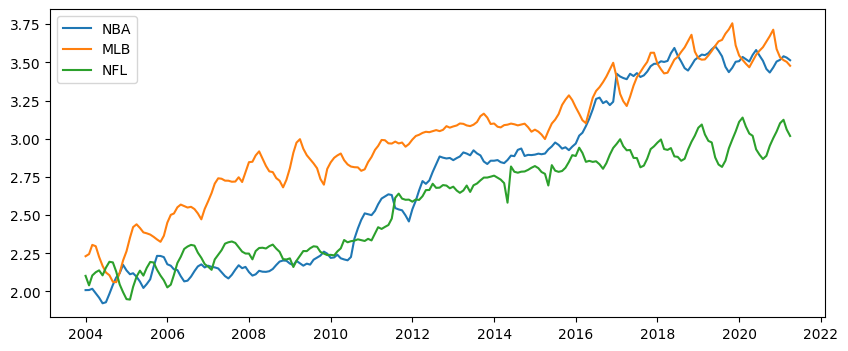

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(nba_expsmth_a, label='NBA')
plt.plot(mlb_expsmth_a, label='MLB')
plt.plot(nfl_expsmth_a, label='NFL')
plt.legend()
plt.show()

In the adjusted plot, the data from March 2020 to March 2021 has been smoothed out by using the average values from 2018 to 2020, leading to a more stable and continuous trend line. This adjustment reduces the sharp pandemic-related declines and recoveries, providing a cleaner look at the underlying trends without the noise introduced by the pandemic.

Post-adjustment, all three sports exhibit smoother trajectories. For NBA and MLB, the exaggerated pandemic peaks are tempered, aligning more closely with the pre-pandemic trends. The NFL's graph also shows a steadier line, with less disruption visible around 2020.

Comparative Analysis

Comparing the two plots, it's clear that the adjusted data provides a more normalized and potentially insightful view into the long-term trends of these sports leagues' popularity. The smoothing of the pandemic's impact allows for a clearer analysis of growth trends and seasonality without the distortion caused by the unusual events of 2020.

This normalization is particularly useful for stakeholders in sports analytics and marketing, as it offers a view of consumer interest that approximates normal conditions, thereby aiding in strategic planning and forecasting efforts.

The adjustments also help in maintaining consistency in data analysis, providing a basis for more reliable comparisons year over year, particularly for the time during which the data would otherwise be significantly skewed by external factors.

### 3.5 Differencing

NBA

In [ ]:
nba_firstdiff = df['NBA_log'] - df['NBA_log'].shift(1)
nba_seasonal_firstdiff = nba_firstdiff - nba_firstdiff.shift(12)

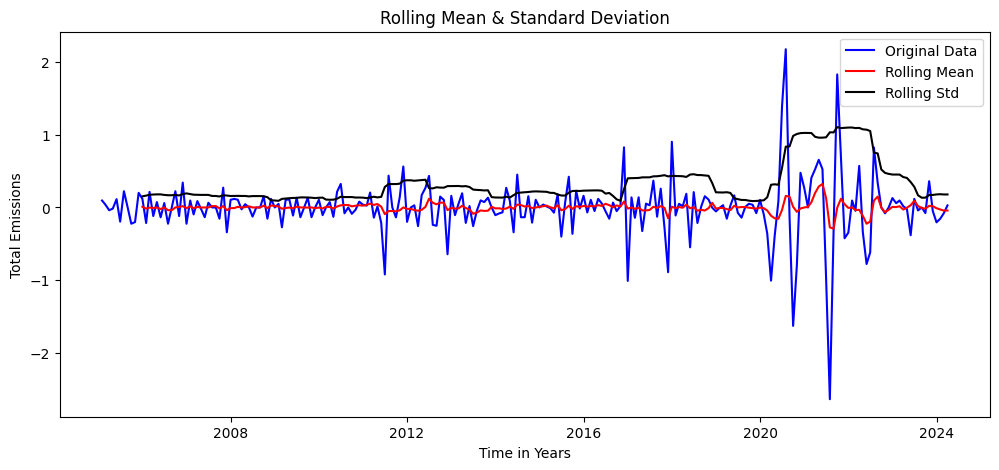

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.886645284485114
p-value : 2.990755882953302e-07
#Lags Used : 15
Number of Observations Used : 215
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


In [ ]:
stationaryplot(nba_seasonal_firstdiff)
adftest(nba_seasonal_firstdiff)

MLB

In [ ]:
mlb_firstdiff = df['MLB_log'] - df['MLB_log'].shift(1)
mlb_seasonal_firstdiff = mlb_firstdiff - mlb_firstdiff.shift(12)

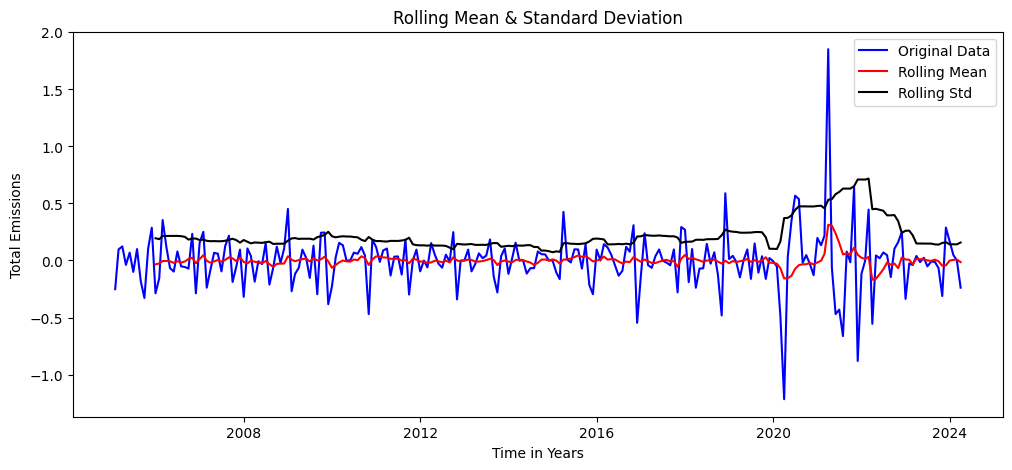

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.788535602446152
p-value : 2.3974134485274698e-09
#Lags Used : 15
Number of Observations Used : 215
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


In [ ]:
stationaryplot(mlb_seasonal_firstdiff)
adftest(mlb_seasonal_firstdiff)

NFL

In [ ]:
nfl_firstdiff = df['NFL_log'] - df['NFL_log'].shift(1)
nfl_seasonal_firstdiff = nfl_firstdiff - nfl_firstdiff.shift(12)

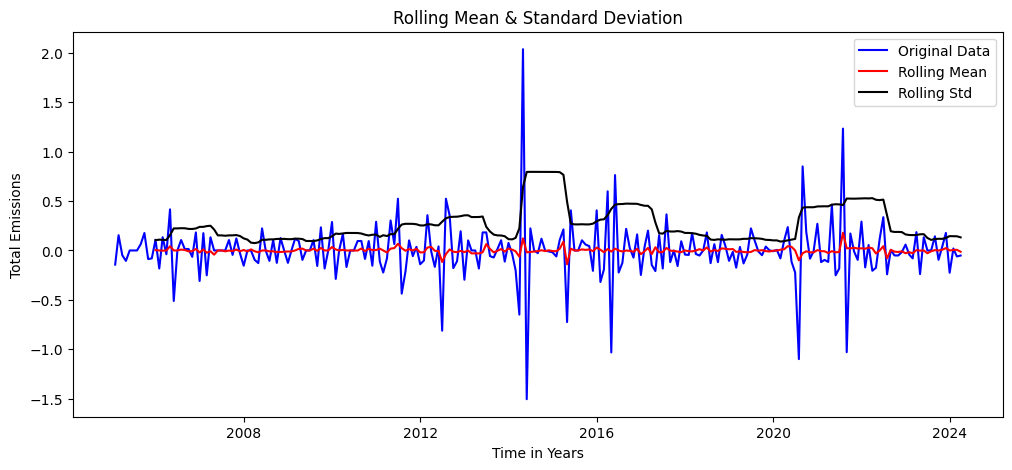

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.977189996391402
p-value : 1.8753164978908037e-07
#Lags Used : 15
Number of Observations Used : 215
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


In [ ]:
stationaryplot(nfl_seasonal_firstdiff)
adftest(nfl_seasonal_firstdiff)

### 3.6 Linear Regression

we want to use linear regression to fit the trend and seasonality intending to retrieve a stationary residuals

Originial

In [ ]:
x = df_train.loc[:,['t','t2','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11']]
x = sm.add_constant(x)
y_nba = df_train.loc[:,'NBA_log']
y_mlb = df_train.loc[:,'MLB_log']
y_nfl = df_train.loc[:,'NFL_log']

Adjusted

In [ ]:
x_a = df_adjusted.loc[:,['t','t2','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11']]
x_a = sm.add_constant(x_a)
y_nba_a = df_adjusted.loc[:,'NBA_log']
y_mlb_a = df_adjusted.loc[:,'MLB_log']
y_nfl_a = df_adjusted.loc[:,'NFL_log']

NBA

In [ ]:
# NBA Linear Regression for trend and seasonality
nba_lr = sm.OLS(y_nba, x).fit()
print(nba_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                NBA_log   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     70.30
Date:                Sat, 04 May 2024   Prob (F-statistic):           4.93e-66
Time:                        15:42:48   Log-Likelihood:                -50.569
No. Observations:                 208   AIC:                             129.1
Df Residuals:                     194   BIC:                             175.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9694      0.101     19.476      0.0

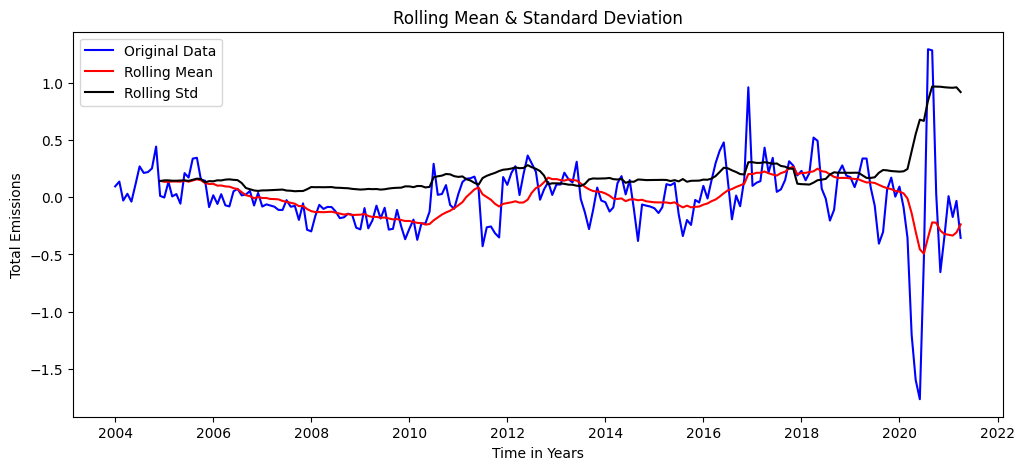

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.498018864877405
p-value : 0.1159571007661589
#Lags Used : 15
Number of Observations Used : 192
Weak evidence against null hypothesis. Time series is non-stationary.


In [ ]:
stationaryplot(nba_lr.resid)
adftest(nba_lr.resid)

The inability to reject the null hypothesis of non-stationarity in the residuals suggests that despite the regression model capturing a significant portion of the variability in the NBA data, there are still some time-dependent structures not explained by the model. This could be due to:

Inadequate modeling of the trend (perhaps the quadratic term isn't capturing the complexity of the trend over time).

Seasonal effects not fully captured by the monthly dummies, possibly requiring a different approach or additional variables to capture more complex seasonal patterns.

The impact of external factors not included in the model, such as economic conditions, strikes, or significant changes in the league's popularity due to stars or exciting games.

NBA adjusted

In [ ]:
nba_lr_a = sm.OLS(y_nba_a, x_a).fit()
print(nba_lr_a.summary())

                            OLS Regression Results                            
Dep. Variable:                NBA_log   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     224.2
Date:                Sat, 04 May 2024   Prob (F-statistic):          3.41e-109
Time:                        15:42:48   Log-Likelihood:                 52.902
No. Observations:                 208   AIC:                            -77.80
Df Residuals:                     194   BIC:                            -31.08
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0272      0.062     32.644      0.0

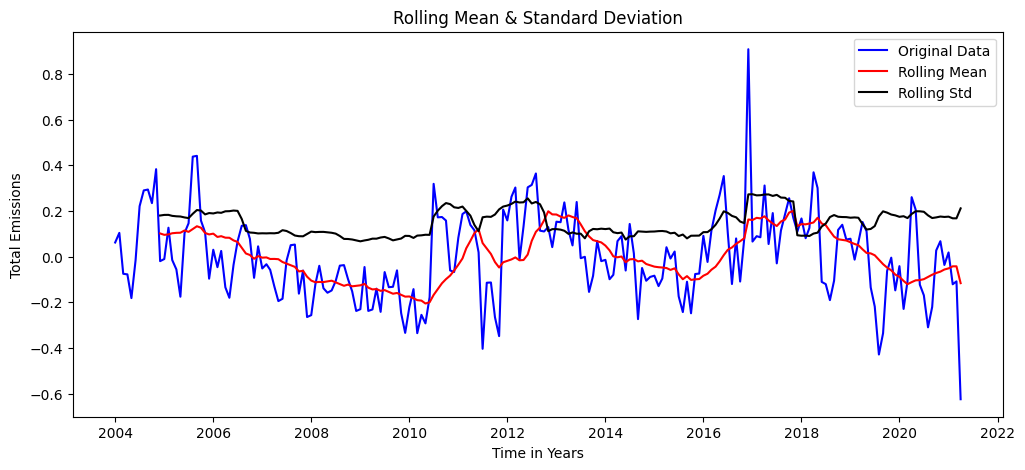

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.1438200575226145
p-value : 0.22726310296406876
#Lags Used : 15
Number of Observations Used : 192
Weak evidence against null hypothesis. Time series is non-stationary.


In [ ]:
stationaryplot(nba_lr_a.resid)
adftest(nba_lr_a.resid)

The inability to achieve stationary residuals implies that while the model effectively captures a significant portion of the underlying patterns in the data, some aspects of the time series dynamics, potentially deeper seasonal effects, longer-term trends, or other cyclic behaviors, are not fully explained. This non-stationarity in the residuals suggests that the model may need further refinement to capture additional complexities in the data or that alternative modeling techniques may be required.

Comparative Analysis

Comparing the linear regression results for the NBA data before and after adjustments for the COVID-19 pandemic offers insightful revelations about the models' performances and underlying data characteristics. Initially, the original model, with an R-squared of 0.825, suggested a decent fit, explaining approximately 82.5% of the variance in the NBA's log-transformed popularity. However, the adjusted model demonstrated a significant improvement, with an R-squared value of 0.938. This indicates a superior fit, which can be attributed to the reduction of volatility and anomalies by normalizing the pandemic's effects, thus allowing for a clearer analysis of underlying trends.

The examination of the coefficients revealed consistency in the significance across both models, particularly during the NBA's active and off-seasons. This consistency highlights the robustness of the seasonal impact on NBA popularity, unaffected by the data adjustments for pandemic impacts. Both models, however, exhibited high condition numbers, suggesting multicollinearity issues primarily due to the many dummy variables and time trends included. This complication could potentially compromise the precision of the coefficient estimates. Moreover, the Durbin-Watson statistics in both cases indicated positive autocorrelation, an aspect that could undermine the independence of residuals and affect the models' reliability.

Interestingly, despite the improvements in model fit seen in the adjusted model, both sets of residuals remained non-stationary. This persistent non-stationarity indicates that essential trends or cyclic patterns were still not fully captured by either model. The non-stationarity of residuals in both the original and adjusted models suggests that more sophisticated modeling approaches may be required. These approaches could include variable selection strategies to address multicollinearity or potentially employing more complex time series techniques like ARIMA models, which might more adeptly handle the intricate dynamics and dependencies present in the data.

Overall, while the adjusted model shows improved fit and robustness in capturing seasonal effects, underlying issues with data independence and multicollinearity, along with the challenge of achieving stationary residuals, highlight the need for further refinement of the models or exploration of alternative statistical methods to fully uncover and accurately model the underlying patterns in NBA popularity data.

MLB

In [ ]:
# MLB Linear Regression for trend and seasonality
mlb_lr = sm.OLS(y_mlb, x).fit()
print(mlb_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                MLB_log   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     86.22
Date:                Sat, 04 May 2024   Prob (F-statistic):           3.60e-73
Time:                        15:42:49   Log-Likelihood:                -30.044
No. Observations:                 208   AIC:                             88.09
Df Residuals:                     194   BIC:                             134.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4981      0.092     16.351      0.0

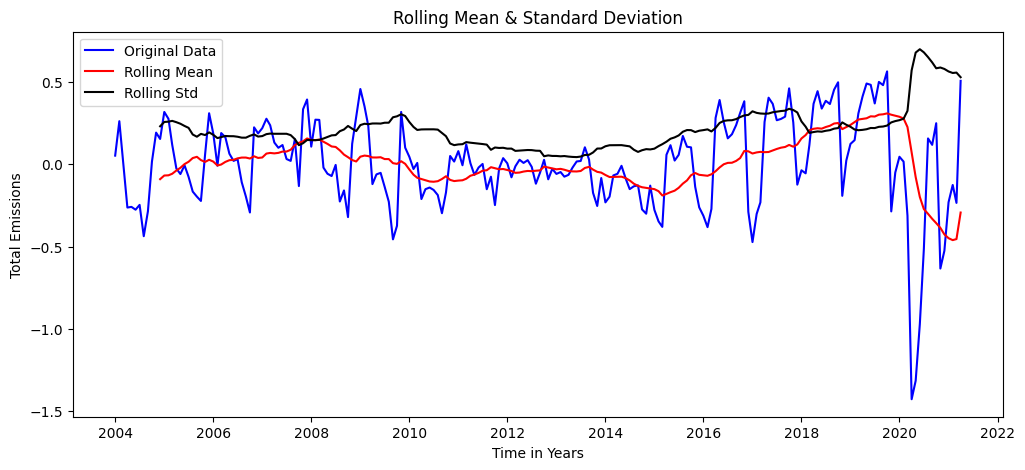

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.896382420735476
p-value : 0.04577029286533453
#Lags Used : 15
Number of Observations Used : 192
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


In [ ]:
stationaryplot(mlb_lr.resid)
adftest(mlb_lr.resid)

The Ordinary Least Squares (OLS) regression analysis for the MLB log-transformed data successfully explains a significant portion of the variability in the MLB's popularity trends and seasonality. The model achieves an R-squared of 0.852, indicating that approximately 85.2% of the variation in MLB log popularity is accounted for by the model's predictors, which include both linear and quadratic time trends and monthly dummies. This high R-squared value, along with an F-statistic of 86.22 significant at a very low p-value, strongly supports the model's effectiveness.

The coefficients for the months, particularly from March through October, are significant, reflecting the MLB season's impact on search popularity. Notably, coefficients for off-season months like January and November are not significant, which aligns with expectations of lower interest outside the baseball season. The model's diagnostics suggest potential issues with multicollinearity, as indicated by a very high condition number, but this is a common occurrence in models with time variables and many dummy indicators.

Moreover, the stationarity of the residuals, confirmed by the Augmented Dickey-Fuller test with an ADF statistic of -2.896 and a p-value of 0.04577, suggests that the model residuals do not exhibit any clear patterns or trends over time, thus affirming the model's adequacy in capturing underlying time-dependent structures in the data. This stationarity is crucial for validating the regression model's specifications and ensuring that the residuals are primarily random noise, free from trends or seasonality not captured by the model.

MLB adjusted

In [ ]:
mlb_lr_a = sm.OLS(y_mlb_a, x_a).fit()
print(mlb_lr_a.summary())

                            OLS Regression Results                            
Dep. Variable:                MLB_log   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     172.3
Date:                Sat, 04 May 2024   Prob (F-statistic):           6.21e-99
Time:                        15:42:50   Log-Likelihood:                 30.073
No. Observations:                 208   AIC:                            -32.15
Df Residuals:                     194   BIC:                             14.58
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5824      0.069     22.832      0.0

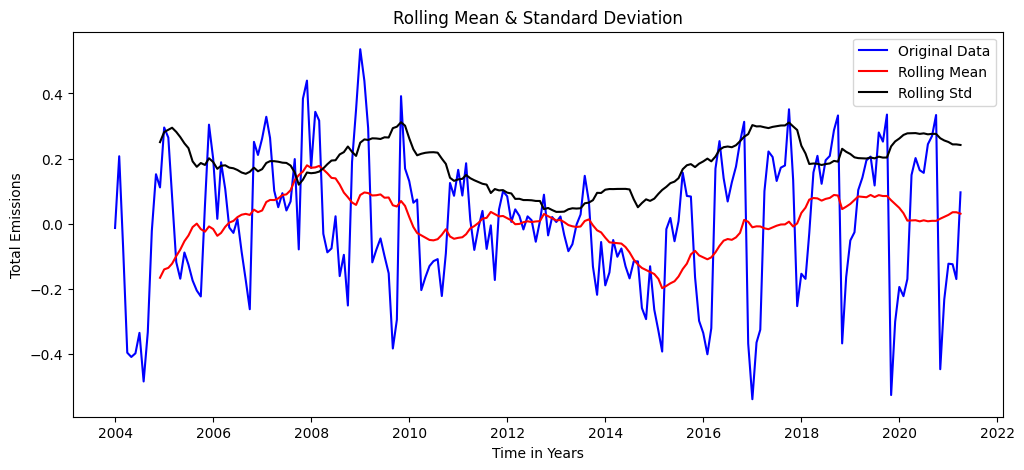

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.1354372186990758
p-value : 0.2305058529274932
#Lags Used : 15
Number of Observations Used : 192
Weak evidence against null hypothesis. Time series is non-stationary.


In [ ]:
stationaryplot(mlb_lr_a.resid)
adftest(mlb_lr_a.resid)


The adjusted Ordinary Least Squares (OLS) regression model for the MLB log-transformed data, modified to account for external impacts such as the COVID-19 pandemic, showcases significant improvements in fitting the data. The model attains an R-squared of 0.920, indicating that it now accounts for 92% of the variability in MLB popularity, a notable increase compared to the previous model's 85.2%. This suggests that the adjustments made to normalize the pandemic effects have allowed the model to better capture the inherent trends and seasonalities in MLB popularity without the distortions caused by extraordinary events.

The model coefficients, particularly for the active MLB season from March through October, are significantly positive, aligning with the expected increase in interest during these months. Negative coefficients in the off-season (such as January) and statistically insignificant coefficients for months like November align with lower fan engagement outside the main season. This model, with its focused adjustments and higher explanatory power, however, still faces potential issues indicated by a large condition number, suggesting multicollinearity remains a concern.

Despite these improvements in the model’s fit and explanatory power, the Augmented Dickey-Fuller test on the model's residuals returns an ADF statistic of -2.135 and a p-value of 0.230, indicating that the residuals are still non-stationary. This non-stationarity suggests that there are still some time-dependent structures or patterns in the data that the model does not fully account for, possibly more complex cyclic or seasonal effects or other non-linear dynamics not captured by the current model specification.

NFL

In [ ]:
# NFL Linear Regression for trend and seasonality
nfl_lr = sm.OLS(y_nfl, x).fit()
print(nfl_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                NFL_log   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     194.9
Date:                Sat, 04 May 2024   Prob (F-statistic):          1.06e-103
Time:                        15:42:50   Log-Likelihood:                 20.873
No. Observations:                 208   AIC:                            -13.75
Df Residuals:                     194   BIC:                             32.98
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7836      0.072     38.809      0.0

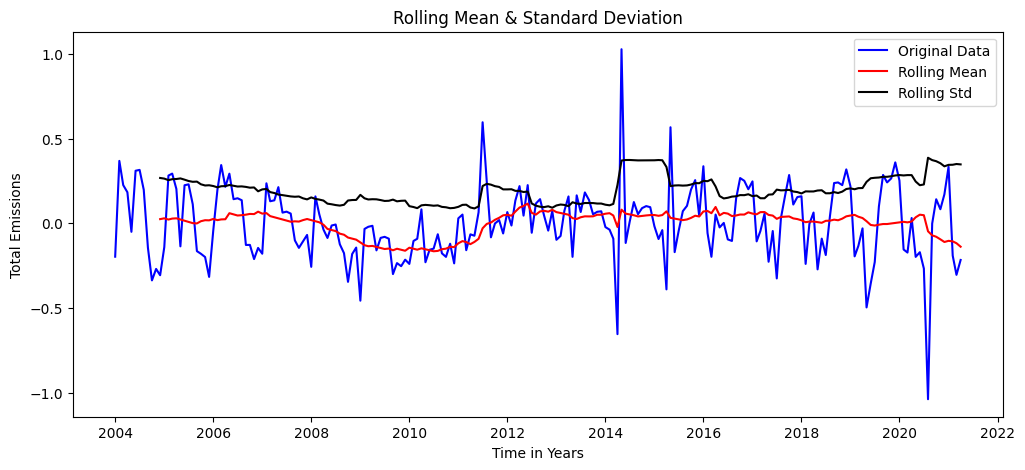

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.2908909252523557
p-value : 0.6333293540850153
#Lags Used : 15
Number of Observations Used : 192
Weak evidence against null hypothesis. Time series is non-stationary.


In [ ]:
stationaryplot(nfl_lr.resid)
adftest(nfl_lr.resid)

NFL adjusted

In [ ]:
nfl_lr_a = sm.OLS(y_nfl_a, x_a).fit()
print(nfl_lr_a.summary())

                            OLS Regression Results                            
Dep. Variable:                NFL_log   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     222.2
Date:                Sat, 04 May 2024   Prob (F-statistic):          7.53e-109
Time:                        15:42:51   Log-Likelihood:                 32.880
No. Observations:                 208   AIC:                            -37.76
Df Residuals:                     194   BIC:                             8.966
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8119      0.068     41.125      0.0

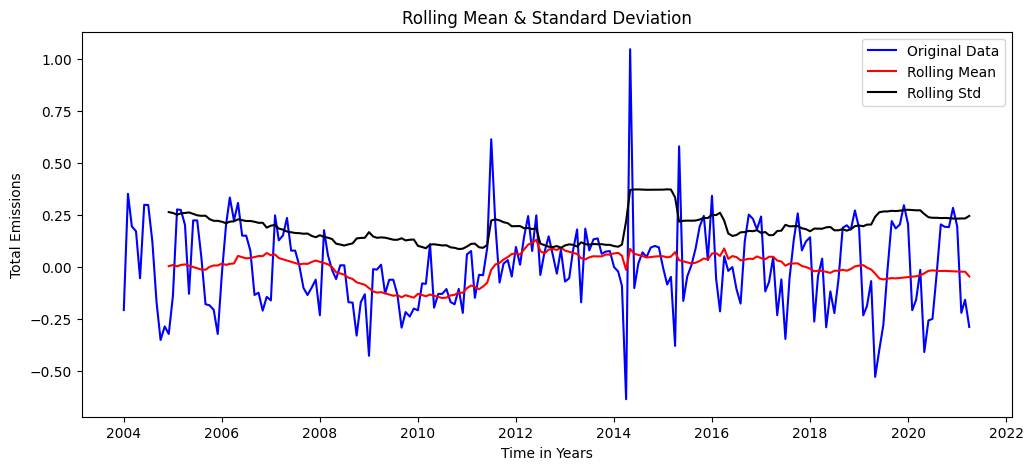

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7425397804471117
p-value : 0.40933861899421514
#Lags Used : 15
Number of Observations Used : 192
Weak evidence against null hypothesis. Time series is non-stationary.


In [ ]:
stationaryplot(nfl_lr_a.resid)
adftest(nfl_lr_a.resid)

## 4. Forecast

### 4.1 ARMA + Trend + Seasonality

use nba_season, mlb_season, nfl_season for seasonality and obtain trend from linear regression.

In [ ]:
## Use Polynomial Regression to obtain the trend
## Does not work well

# x_t_train = df_train[['t','t2']]
# x_t = df[['t','t2']]

# nba_trend = sm.OLS(y_nba,x_t_train).fit().predict(x_t)
# mlb_trend = sm.OLS(y_mlb,x_t_train).fit().predict(x_t)
# nfl_trend = sm.OLS(y_nfl,x_t_train).fit().predict(x_t)

In [ ]:
def arma_grid_search(data, p_values, q_values):
    data_clean = data.dropna()
    best_mse, best_bic = float("inf"), float("inf")
    best_cfg_mse, best_cfg_bic = None, None
    results = []

    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(data_clean, order=(p, 0, q))
                model_fit = model.fit()

                model_mse = np.mean(np.square(model_fit.resid))
                model_bic = model_fit.bic

                results.append((p, q, model_mse, model_bic))

                if model_mse < best_mse:
                    best_mse, best_cfg_mse = model_mse, (p, q)

                if model_bic < best_bic:
                    best_bic, best_cfg_bic = model_bic, (p, q)

            except Exception as e:
                print(f"Failed to fit ARMA({p},{q}): {e}")

    return best_cfg_mse, best_cfg_bic, results

In [ ]:
p = range(1,6)
q = range(1,6)

Original

In [ ]:
nba_resid.dropna(inplace=True)
mlb_resid.dropna(inplace=True)
nfl_resid.dropna(inplace=True)

In [ ]:
# arma_grid_search(nba_resid, p, q)

In [ ]:
# arma_grid_search(mlb_resid, p, q)

In [ ]:
# arma_grid_search(nfl_resid, p, q)

In [ ]:
# NBA
nba_model1 = ARIMA(nba_resid, order=(5,0,3))
nba_model2 = ARIMA(nba_resid, order=(2,0,1))
nba_result1 = nba_model1.fit()
nba_result2 = nba_model2.fit()

In [ ]:
nba_predict1 = nba_result1.predict(start= 0, end = len(df_train)-7)
nba_forecast1 = nba_result1.forecast(steps = len(df_test)+6)

In [ ]:
nba_fullpred1 = nba_predict1 + nba_season + moving_avg['NBA_log']
nba_fullpred1.dropna(inplace=True)

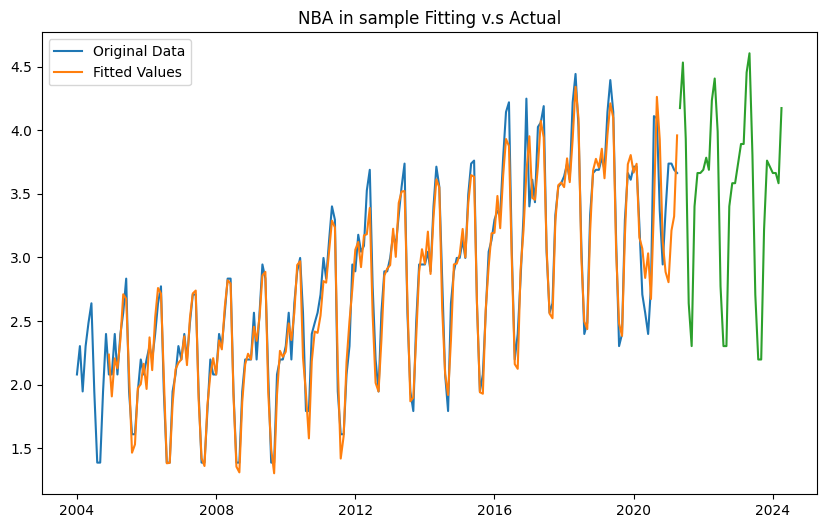

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NBA_log'], label='Original Data')
plt.plot(nba_fullpred1, label='Fitted Values')
plt.plot(df_test['NBA_log'])
plt.title('NBA in sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
test_index = pd.date_range(start='2021-05-01', end='2024-04-01', freq='MS')

In [ ]:
# NBA test set
nba_test_resid = nba_forecast1[6:]
nba_test_trend = moving_avg['NBA_log'][-1]
nba_test_season = pd.Series([nba_season[i.month - 1] for i in test_index], index=test_index)

nba_test_forecast = nba_test_resid + nba_test_season + nba_test_trend

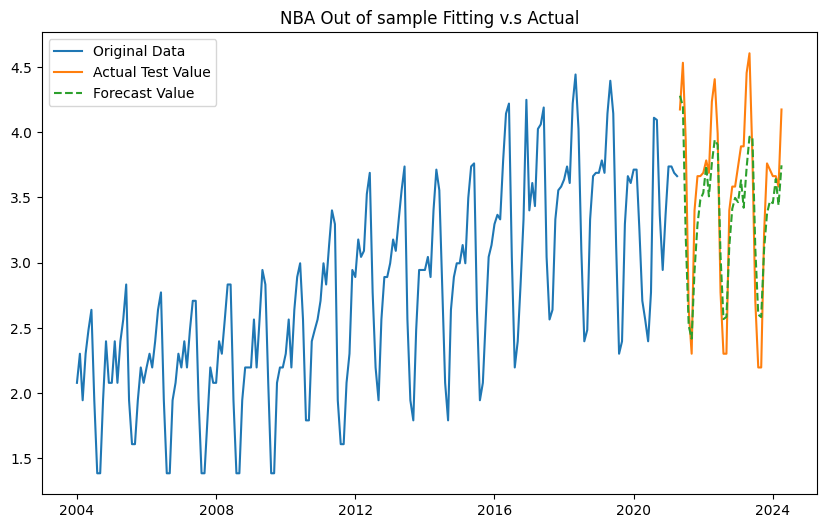

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NBA_log'], label='Original Data')
plt.plot(df_test['NBA_log'], label='Actual Test Value')
plt.plot(nba_test_forecast, label='Forecast Value', linestyle='--')
plt.title('NBA Out of sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
nba_rmse = np.sqrt(((nba_test_forecast - df_test['NBA_log'])**2).mean())
print(f'NBA RMSE of Original data is: ', nba_rmse)

NBA RMSE of Original data is:  0.3412194113298693


In [ ]:
# MLB
mlb_model1 = ARIMA(mlb_resid, order=(3,0,4))
mlb_model2 = ARIMA(mlb_resid, order=(2,0,1))
mlb_result1 = mlb_model1.fit()
mlb_result2 = mlb_model2.fit()

In [ ]:
mlb_predict1 = mlb_result1.predict(start= 0, end = len(df_train)-7)
mlb_forecast1 = mlb_result1.forecast(steps = len(df_test)+6)

In [ ]:
mlb_fullpred1 = mlb_predict1 + mlb_season + moving_avg['MLB_log']
mlb_fullpred1.dropna(inplace=True)

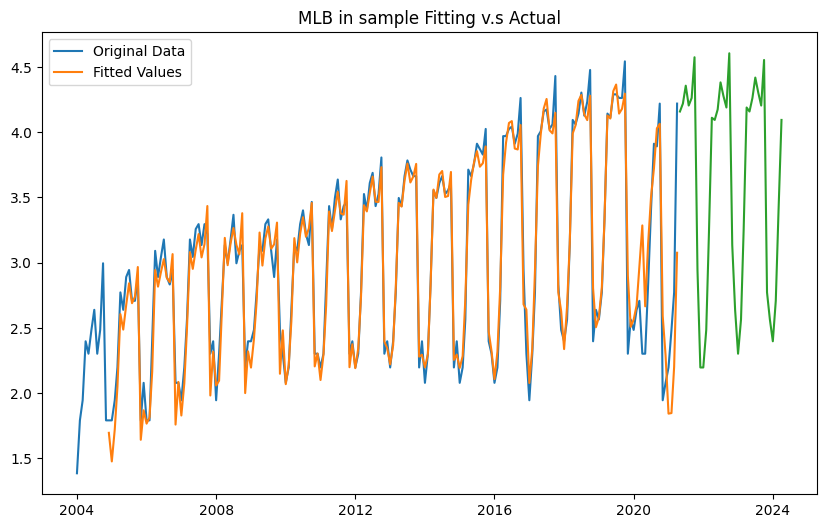

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['MLB_log'], label='Original Data')
plt.plot(mlb_fullpred1, label='Fitted Values')
plt.plot(df_test['MLB_log'])
plt.title('MLB in sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
# MLB test set
mlb_test_resid = mlb_forecast1[6:]
mlb_test_trend = moving_avg['MLB_log'][-12]
mlb_test_season = pd.Series([mlb_season[i.month - 1] for i in test_index], index=test_index)

mlb_test_forecast = mlb_test_resid + mlb_test_season + mlb_test_trend

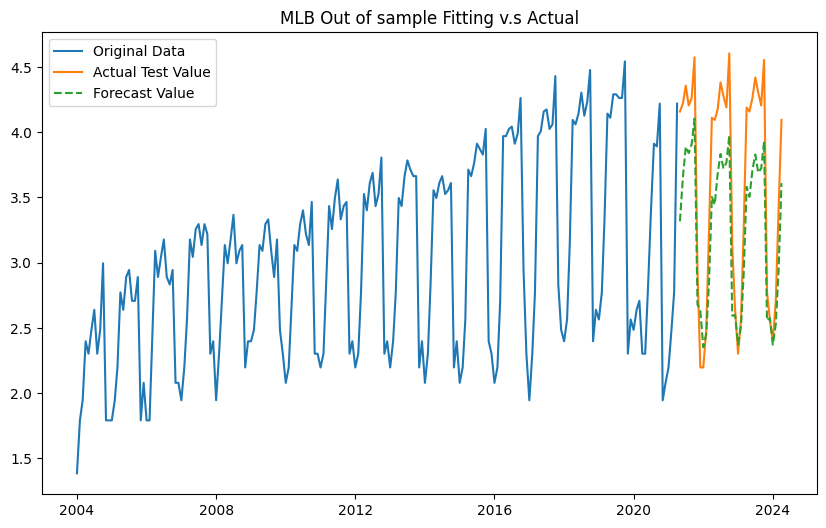

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['MLB_log'], label='Original Data')
plt.plot(df_test['MLB_log'], label='Actual Test Value')
plt.plot(mlb_test_forecast, label='Forecast Value', linestyle='--')
plt.title('MLB Out of sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
mlb_rmse = np.sqrt(((mlb_test_forecast - df_test['MLB_log'])**2).mean())
print(f'MLB RMSE of Original data is: ', mlb_rmse)

MLB RMSE of Original data is:  0.46489119359030806


In [ ]:
# NFL
nfl_model1 = ARIMA(nfl_resid, order=(4,0,5))
nfl_model2 = ARIMA(nfl_resid, order=(3,0,2))
nfl_result1 = nfl_model1.fit()
nfl_result2 = nfl_model2.fit()

In [ ]:
nfl_predict1 = nfl_result1.predict(start= 0, end = len(df_train)-7)
nfl_forecast1 = nfl_result1.forecast(steps = len(df_test)+6)

In [ ]:
nfl_fullpred1 = nfl_predict1 + nfl_season + moving_avg['NFL_log']
nfl_fullpred1.dropna(inplace=True)

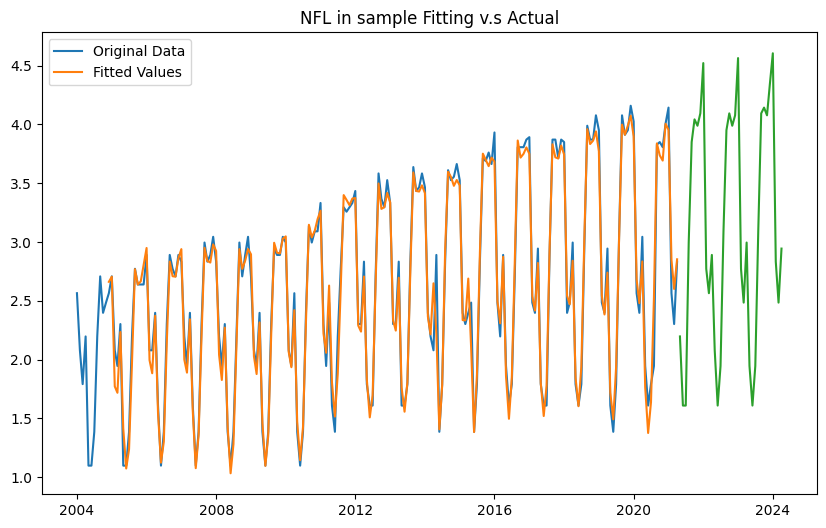

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NFL_log'], label='Original Data')
plt.plot(nfl_fullpred1, label='Fitted Values')
plt.plot(df_test['NFL_log'])
plt.title('NFL in sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
# NFL test set
nfl_test_resid = nfl_forecast1[6:]
nfl_test_trend = moving_avg['NFL_log'][-12]
nfl_test_season = pd.Series([nfl_season[i.month - 1] for i in test_index], index=test_index)

nfl_test_forecast = nfl_test_resid + nfl_test_season + nfl_test_trend

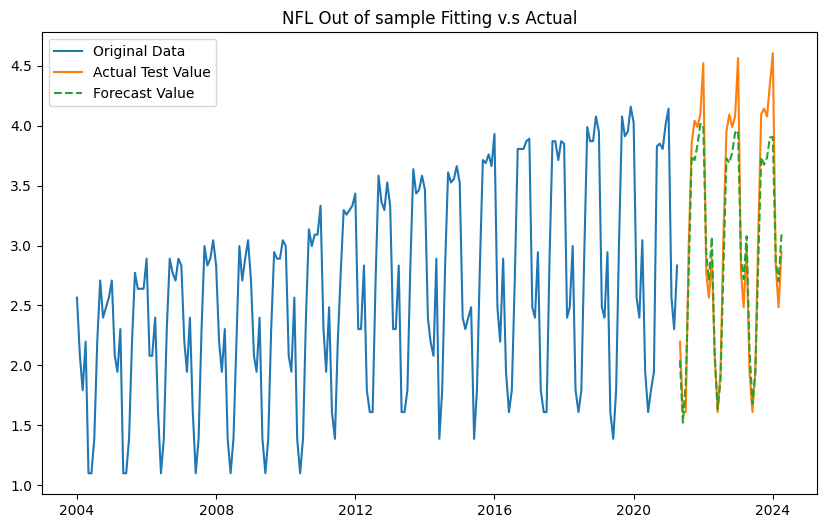

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NFL_log'], label='Original Data')
plt.plot(df_test['NFL_log'], label='Actual Test Value')
plt.plot(nfl_test_forecast, label='Forecast Value', linestyle='--')
plt.title('NFL Out of sample Fitting v.s Actual')
plt.legend()
plt.show()

In [ ]:
nfl_rmse = np.sqrt(((nfl_test_forecast - df_test['NFL_log'])**2).mean())
print(f'NFL RMSE of Original data is: ', nfl_rmse)

NFL RMSE of Original data is:  0.27584175978546854


Adjusted

In [ ]:
nba_resid_a.dropna(inplace=True)
mlb_resid_a.dropna(inplace=True)
nfl_resid_a.dropna(inplace=True)

In [ ]:
# arma_grid_search(nba_resid_a, p, q)

In [ ]:
# arma_grid_search(mlb_resid_a, p, q)

In [ ]:
# arma_grid_search(nfl_resid_a, p, q)

In [ ]:
# NBA training
nba_model1_a = ARIMA(nba_resid_a, order=(5,0,4))
nba_model2_a = ARIMA(nba_resid_a, order=(2,0,2))
nba_result1_a = nba_model1_a.fit()
nba_result2_a = nba_model2_a.fit()

nba_predict1_a = nba_result1_a.predict(start= 0, end = len(df_adjusted)-7)
nba_forecast1_a = nba_result1_a.forecast(steps = len(df_test)+6)

nba_fullpred1_a = nba_predict1_a + nba_season_a + moving_avg_a['NBA_log']
nba_fullpred1_a.dropna(inplace=True)

In [ ]:
# NBA test set
nba_test_resid_a = nba_forecast1_a[6:]
nba_test_trend_a = moving_avg_a['NBA_log'][-1]
nba_test_season_a = pd.Series([nba_season_a[i.month - 1] for i in test_index], index=test_index)

nba_test_forecast_a = nba_test_resid_a + nba_test_season_a + nba_test_trend_a

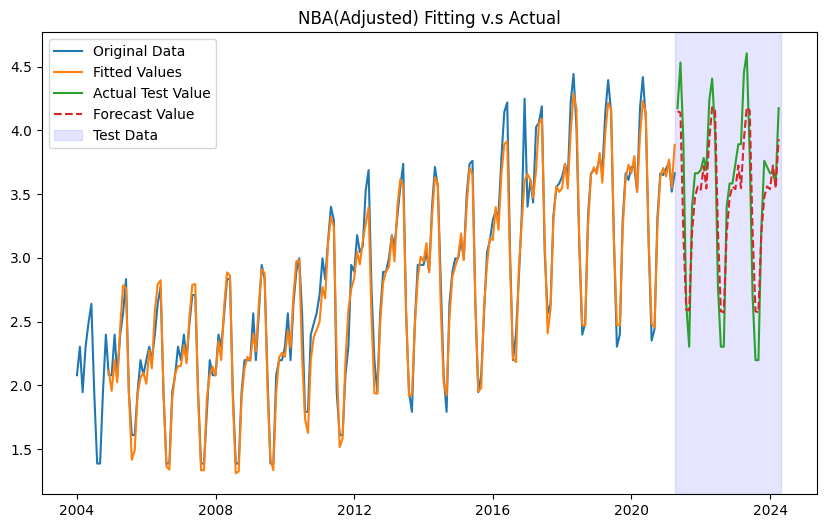

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_adjusted['NBA_log'], label='Original Data')
plt.plot(nba_fullpred1_a, label='Fitted Values')
plt.plot(df_test['NBA_log'], label='Actual Test Value')
plt.plot(nba_test_forecast_a, label='Forecast Value', linestyle='--')
plt.title('NBA(Adjusted) Fitting v.s Actual')
plt.axvspan('2021-04-01', '2024-05-01', color='blue', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nba_rmse_a = np.sqrt(((nba_test_forecast_a - df_test['NBA_log'])**2).mean())
print(f'NBA RMSE after adjusting data is: ', nba_rmse_a)


NBA RMSE after adjusting data is:  0.2865439761397733


In [ ]:
# MLB training
mlb_model1_a = ARIMA(mlb_resid_a, order=(3,0,5))
mlb_model2_a = ARIMA(mlb_resid_a, order=(2,0,2))
mlb_result1_a = mlb_model1_a.fit()
mlb_result2_a = mlb_model2_a.fit()

mlb_predict1_a = mlb_result1_a.predict(start= 0, end = len(df_adjusted)-7)
mlb_forecast1_a = mlb_result1_a.forecast(steps = len(df_test)+6)

mlb_fullpred1_a = mlb_predict1_a + mlb_season_a + moving_avg_a['MLB_log']
mlb_fullpred1_a.dropna(inplace=True)

In [ ]:
# MLB test set
mlb_test_resid_a = mlb_forecast1_a[6:]
mlb_test_trend_a = moving_avg_a['MLB_log'][-1]
mlb_test_season_a = pd.Series([mlb_season_a[i.month - 1] for i in test_index], index=test_index)

mlb_test_forecast_a = mlb_test_resid_a + mlb_test_season_a + mlb_test_trend_a

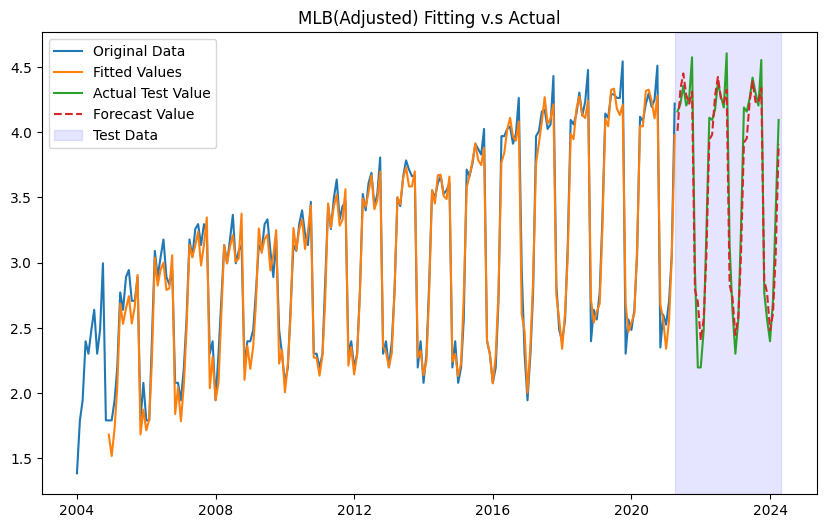

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_adjusted['MLB_log'], label='Original Data')
plt.plot(mlb_fullpred1_a, label='Fitted Values')
plt.plot(df_test['MLB_log'], label='Actual Test Value')
plt.plot(mlb_test_forecast_a, label='Forecast Value', linestyle='--')
plt.title('MLB(Adjusted) Fitting v.s Actual')
plt.axvspan('2021-04-01', '2024-05-01', color='blue', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
mlb_rmse_a = np.sqrt(((mlb_test_forecast_a - df_test['MLB_log'])**2).mean())
print(f'MLB RMSE after adjusting data is: ', mlb_rmse_a)

MLB RMSE after adjusting data is:  0.17930816283259718


In [ ]:
# NFL training
nfl_model1_a = ARIMA(nfl_resid_a, order=(4,0,5))
nfl_model2_a = ARIMA(nfl_resid_a, order=(3,0,2))
nfl_result1_a = nfl_model1_a.fit()
nfl_result2_a = nfl_model2_a.fit()

nfl_predict1_a = nfl_result1_a.predict(start= 0, end = len(df_adjusted)-7)
nfl_forecast1_a = nfl_result1_a.forecast(steps = len(df_test)+6)

nfl_fullpred1_a = nfl_predict1_a + nfl_season_a + moving_avg_a['NFL_log']
nfl_fullpred1_a.dropna(inplace=True)

In [ ]:
# NFL test set
nfl_test_resid_a = nfl_forecast1_a[6:]
nfl_test_trend_a = moving_avg_a['NFL_log'][-1]
nfl_test_season_a = pd.Series([nfl_season_a[i.month - 1] for i in test_index], index=test_index)

nfl_test_forecast_a = nfl_test_resid_a + nfl_test_season_a + nfl_test_trend_a

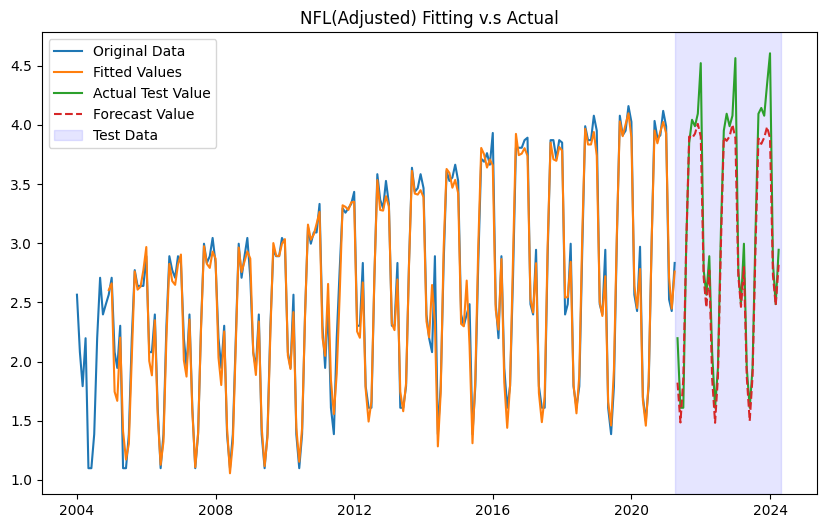

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_adjusted['NFL_log'], label='Original Data')
plt.plot(nfl_fullpred1_a, label='Fitted Values')
plt.plot(df_test['NFL_log'], label='Actual Test Value')
plt.plot(nfl_test_forecast_a, label='Forecast Value', linestyle='--')
plt.title('NFL(Adjusted) Fitting v.s Actual')
plt.axvspan('2021-04-01', '2024-05-01', color='blue', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nfl_rmse_a = np.sqrt(((nfl_test_forecast_a - df_test['NFL_log'])**2).mean())
print(f'NFL RMSE after adjusting data is: ', nfl_rmse_a)

NFL RMSE after adjusting data is:  0.24725913102655675


### 4.2 Holt-Winters Multiplicative Model

In [ ]:
nba_hwmm = ExponentialSmoothing(df_train['NBA_log'], seasonal='mul', seasonal_periods=12).fit()

In [ ]:
forecast_nba = nba_hwmm.forecast(36)

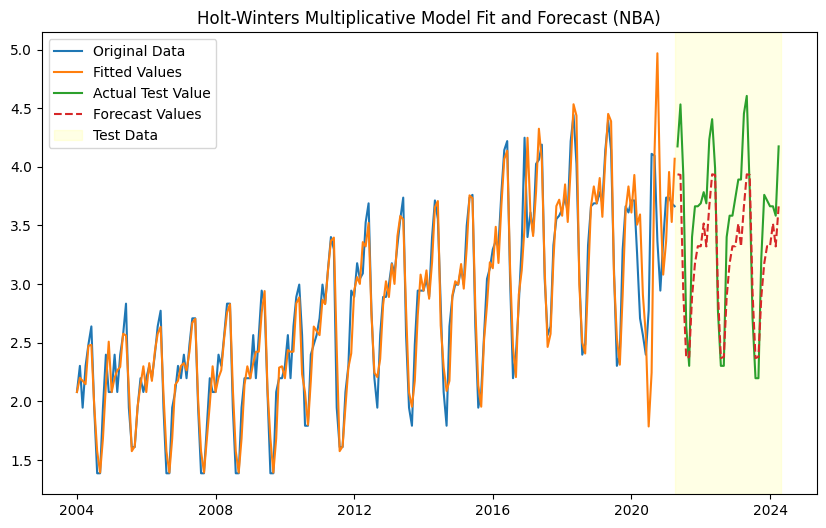

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NBA_log'], label='Original Data')
plt.plot(nba_hwmm.fittedvalues, label='Fitted Values')
plt.plot(df_test['NBA_log'], label='Actual Test Value')
plt.plot(forecast_nba, label='Forecast Values', linestyle='--')
plt.title('Holt-Winters Multiplicative Model Fit and Forecast (NBA)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nba_rmse_hw = np.sqrt(((forecast_nba - df_test['NBA_log'])**2).mean())
print(f'NBA RMSE using HWMM is: ', nba_rmse_hw)

NBA RMSE using HWMM is:  0.4234801183456262


In [ ]:
mlb_hwmm = ExponentialSmoothing(df_train['MLB_log'], seasonal='mul', seasonal_periods=12).fit()

In [ ]:
forecast_mlb = mlb_hwmm.forecast(36)

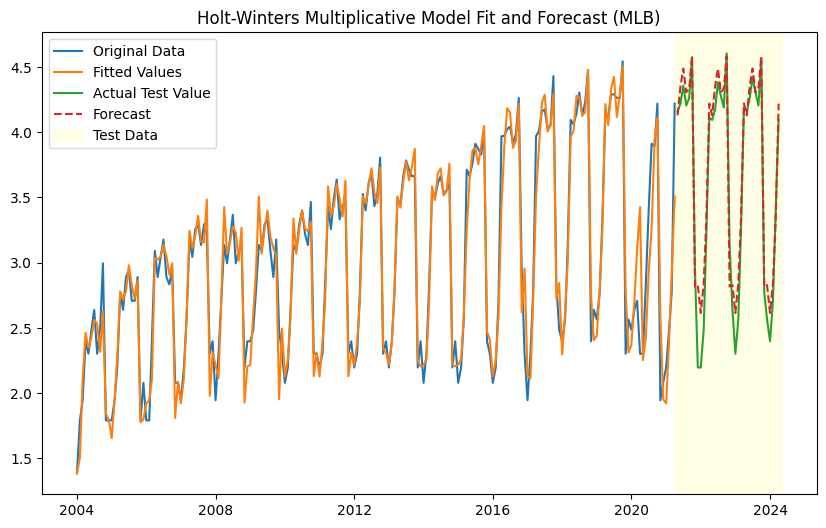

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['MLB_log'], label='Original Data')
plt.plot(mlb_hwmm.fittedvalues, label='Fitted Values')
plt.plot(df_test['MLB_log'], label='Actual Test Value')
plt.plot(forecast_mlb, label='Forecast', linestyle='--')
plt.title('Holt-Winters Multiplicative Model Fit and Forecast (MLB)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
mlb_rmse_hw = np.sqrt(((forecast_mlb - df_test['MLB_log'])**2).mean())
print(f'MLB RMSE using HWMM is: ', mlb_rmse_hw)

MLB RMSE using HWMM is:  0.19452540809429483


In [ ]:
nfl_hwmm = ExponentialSmoothing(df_train['NFL_log'], seasonal='mul', seasonal_periods=12).fit()

In [ ]:
forecast_nfl = nfl_hwmm.forecast(36)

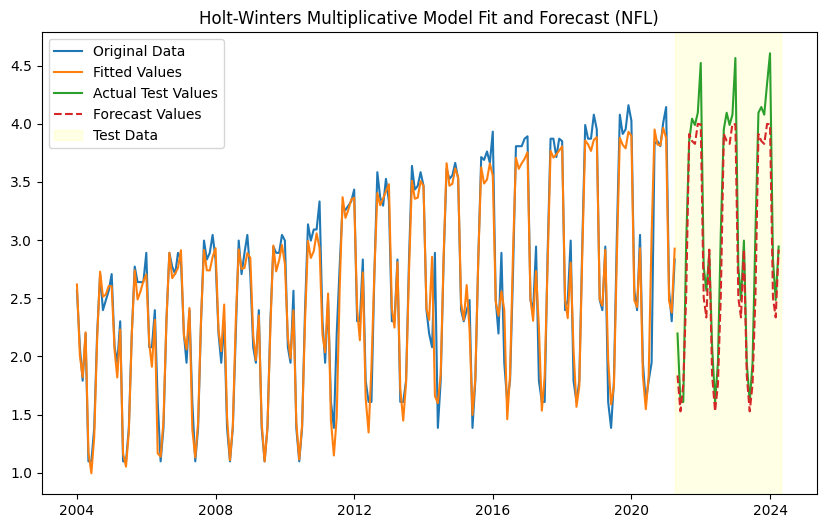

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train['NFL_log'], label='Original Data')
plt.plot(nfl_hwmm.fittedvalues, label='Fitted Values')
plt.plot(df_test['NFL_log'], label='Actual Test Values')
plt.plot(forecast_nfl, label='Forecast Values', linestyle='--')
plt.title('Holt-Winters Multiplicative Model Fit and Forecast (NFL)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nfl_rmse_hw = np.sqrt(((forecast_nfl - df_test['NFL_log'])**2).mean())
print(f'NFL: RMSE using HWMM is: ', nfl_rmse_hw)

NFL: RMSE using HWMM is:  0.2850825009638128


Visualize feature/target relationship

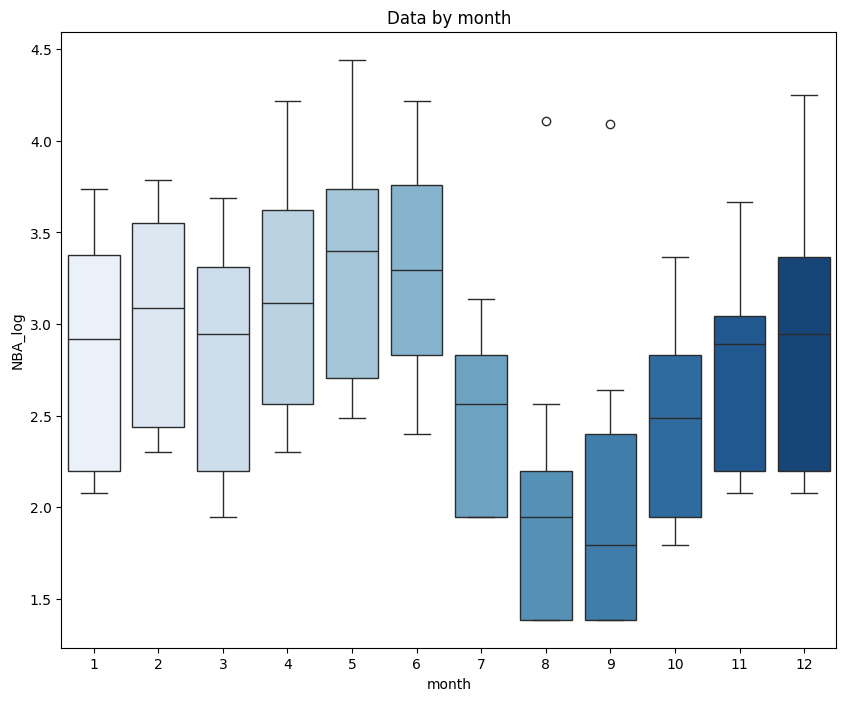

In [ ]:
#NBA data trend per year
import seaborn as sns
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df_train,x='month',y=df_train['NBA_log'],palette='Blues')
ax.set_title('Data by month')

plt.show()

### 4.3 Seasonal ARIMA

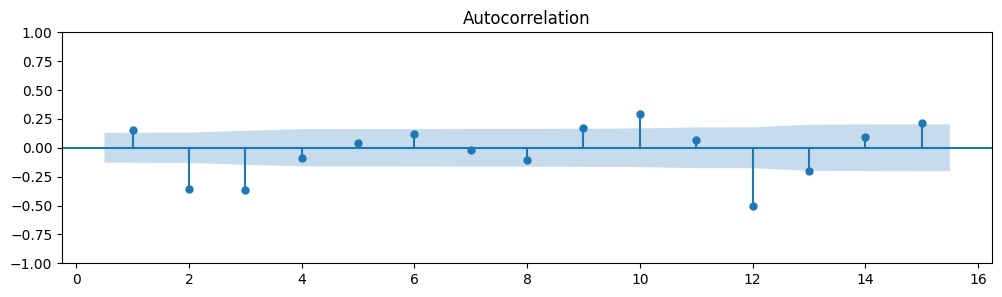

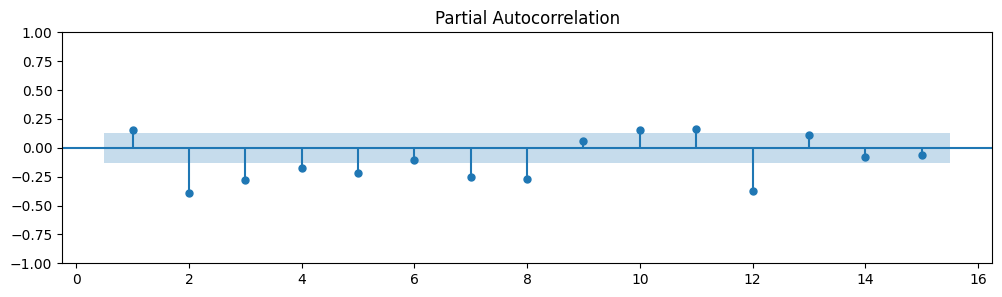

In [ ]:
## NBA
plot_cf(nba_seasonal_firstdiff,lags=15)

In [ ]:
# Fit a SARIMA model
model = sm.tsa.statespace.SARIMAX(df_train['NBA_log'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result = model.fit()
print(result.summary())

model_a = sm.tsa.statespace.SARIMAX(df_adjusted['NBA_log'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result_a = model_a.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              NBA_log   No. Observations:                  208
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                  -1.458
Date:                              Sat, 04 May 2024   AIC                             16.916
Time:                                      15:43:17   BIC                             39.827
Sample:                                  01-01-2004   HQIC                            26.193
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9631      0.096     10.068      0.000       0.776       1.151
ar.L2         -0.54

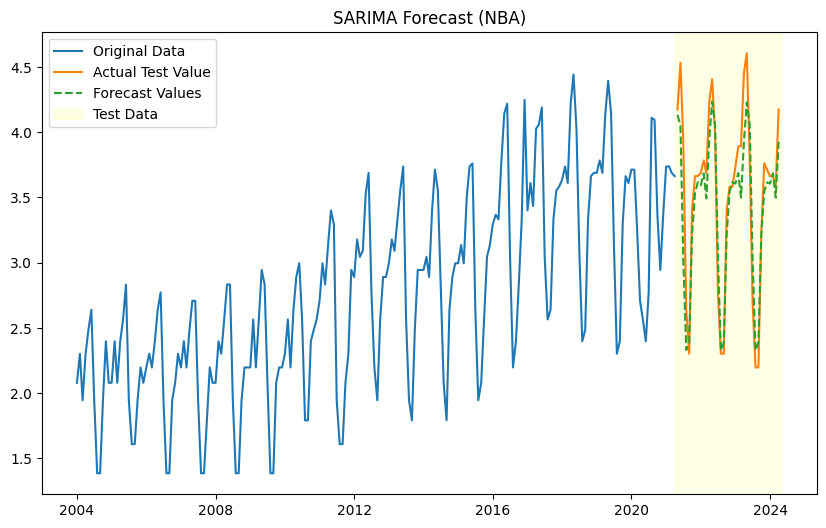

In [ ]:
# adjusted
df['forecast_a']=result_a.predict(start=208,end=244, dynamic=True)

plt.figure(figsize=(10, 6))
plt.plot(df_train['NBA_log'], label='Original Data')
plt.plot(df_test['NBA_log'], label='Actual Test Value')
plt.plot(df['forecast_a'], label='Forecast Values', linestyle='--')
plt.title('SARIMA Forecast (NBA)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nba_rmse_sa = np.sqrt(((df['forecast_a'] - df_test['NBA_log'])**2).mean())
print(f'NBA RMSE using SARI is: ', nba_rmse_sa)

NBA RMSE using SARI is:  0.2636175478905356


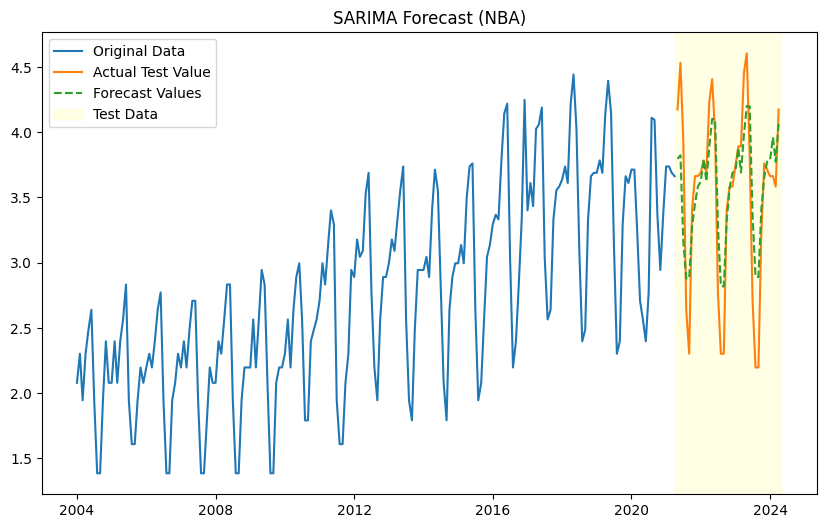

In [ ]:
df['forecast']=result.predict(start=208,end=244, dynamic=True)

plt.figure(figsize=(10, 6))
plt.plot(df_train['NBA_log'], label='Original Data')
plt.plot(df_test['NBA_log'], label='Actual Test Value')
plt.plot(df['forecast'], label='Forecast Values', linestyle='--')
plt.title('SARIMA Forecast (NBA)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[df_nba.index[-1]+DateOffset(month=x)for x in range(0,12)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df_nba.columns)
future_df_nba=pd.concat([df_nba,future_dates_df])
future_df_nba.tail()

NBA: (United States)
2024-07-01                  NaN
2024-08-01                  NaN
2024-09-01                  NaN
2024-10-01                  NaN
2024-11-01                  NaN

In [ ]:
future_df_nba['forecast']=result.predict(start=240,end=280,dynamic=True)

In [ ]:
df_nba['t'] = range(1,len(df_nba)+1)
df_nba

NBA: (United States)    t
Month                                
2004-01-01                     8    1
2004-02-01                    10    2
2004-03-01                     7    3
2004-04-01                    10    4
2004-05-01                    12    5
...                          ...  ...
2023-12-01                    41  240
2024-01-01                    39  241
2024-02-01                    39  242
2024-03-01                    36  243
2024-04-01                    65  244

[244 rows x 2 columns]

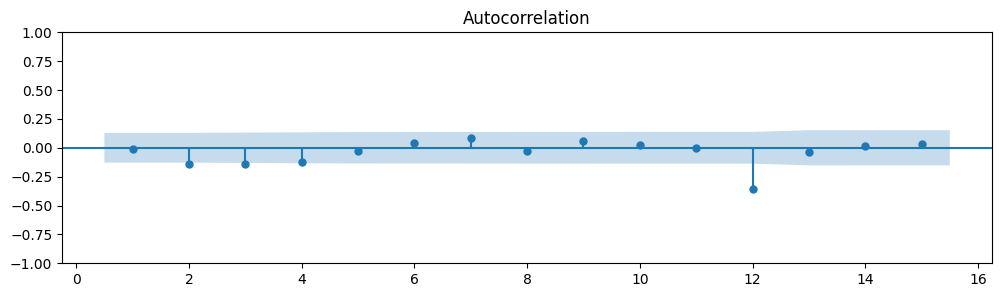

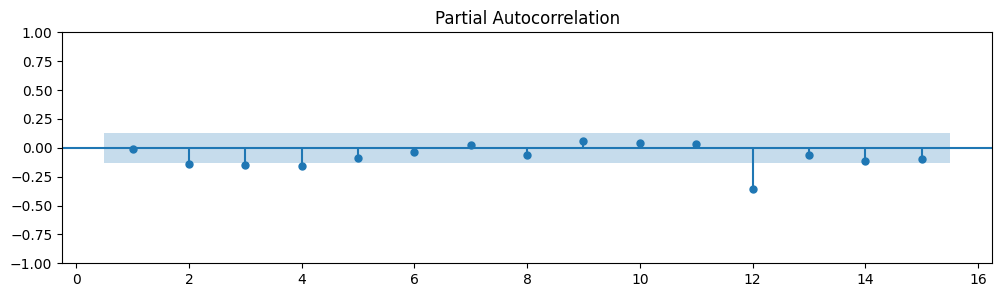

In [ ]:
## MLB case
plot_cf(mlb_seasonal_firstdiff,lags=15)

In [ ]:
# Fit a SARIMA model
model2 = sm.tsa.statespace.SARIMAX(df_train['MLB_log'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
result2 = model2.fit()
print(result2.summary())

model2_a = sm.tsa.statespace.SARIMAX(df_adjusted['MLB_log'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result2_a = model2_a.fit()
print(result2_a.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            MLB_log   No. Observations:                  208
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   2.542
Date:                            Sat, 04 May 2024   AIC                             -3.083
Time:                                    15:43:24   BIC                              0.190
Sample:                                01-01-2004   HQIC                            -1.758
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0570      0.002     33.035      0.000       0.054       0.060
Ljung-Box (L1) (Q):                

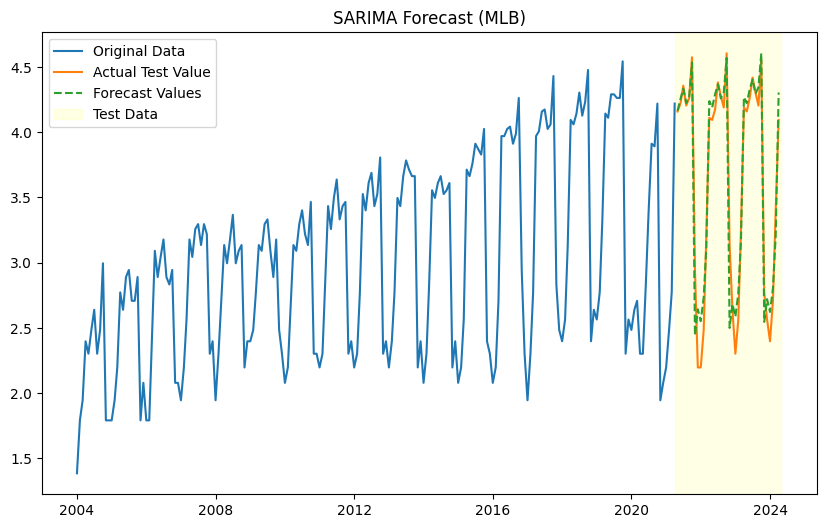

In [ ]:
df['forecast2_a']=result2_a.predict(start=208,end=244,dynamic=True)


plt.figure(figsize=(10, 6))
plt.plot(df_train['MLB_log'], label='Original Data')
plt.plot(df_test['MLB_log'], label='Actual Test Value')
plt.plot(df['forecast2_a'], label='Forecast Values', linestyle='--')
plt.title('SARIMA Forecast (MLB)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
mlb_rmse_sa = np.sqrt(((df['forecast2_a'] - df_test['MLB_log'])**2).mean())
print(f'MLB RMSE using SARI is: ', mlb_rmse_sa)

MLB RMSE using SARI is:  0.20389803526281655


In [ ]:
future_dates_=[df_mlb.index[-1]+DateOffset(month=x)for x in range(0,12)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df_mlb.columns)
future_df_mlb=pd.concat([df_mlb,future_dates_df])
future_df_mlb.tail()

MLB: (United States)
2024-07-01                  NaN
2024-08-01                  NaN
2024-09-01                  NaN
2024-10-01                  NaN
2024-11-01                  NaN

In [ ]:
future_df_mlb['forecast']=result2.predict(start=240,end=280,dynamic=True)

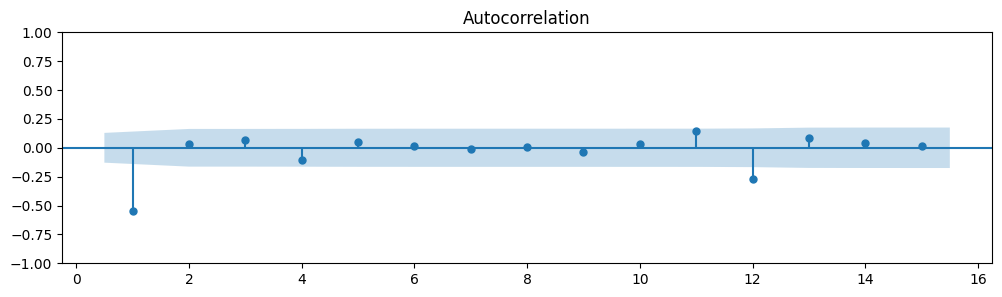

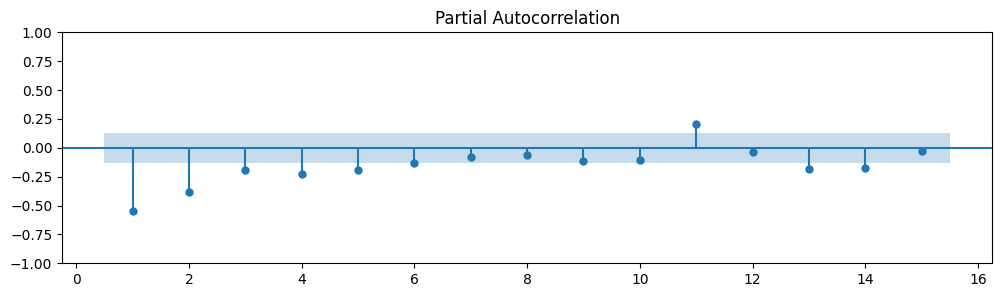

In [ ]:
## NFL case
plot_cf(nfl_seasonal_firstdiff,lags=15)

In [ ]:
# Fit a SARIMA model
model3 = sm.tsa.statespace.SARIMAX(df_train['NFL_log'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 12))
result3 = model3.fit()
print(result3.summary())
#differencing 后的pacf acf
model3_a = sm.tsa.statespace.SARIMAX(df_adjusted['NFL_log'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result3_a = model3_a.fit()
print(result3_a.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            NFL_log   No. Observations:                  208
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                  41.407
Date:                            Sat, 04 May 2024   AIC                            -68.814
Time:                                    15:43:37   BIC                            -45.903
Sample:                                01-01-2004   HQIC                           -59.538
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0250      0.061     -0.411      0.681      -0.144       0.094
ar.L2          0.0280      0.092   

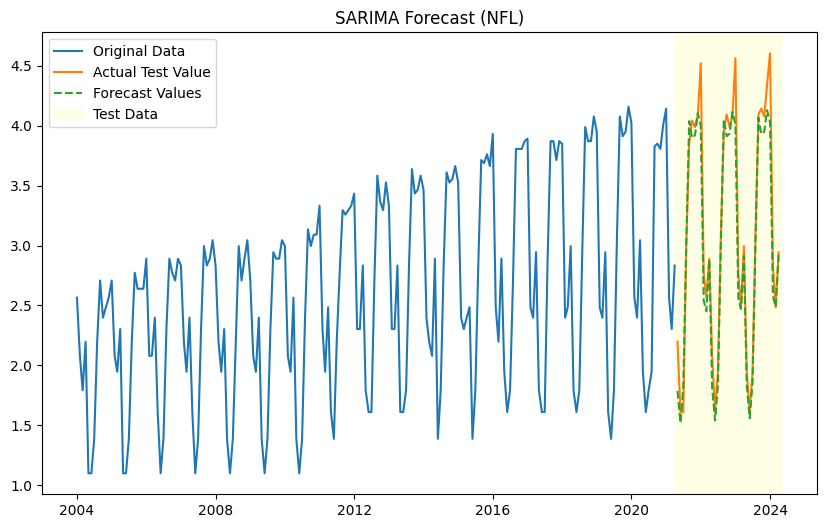

In [ ]:
df['forecast3_a']=result3_a.predict(start=208,end=244,dynamic=True)


plt.figure(figsize=(10, 6))
plt.plot(df_train['NFL_log'], label='Original Data')
plt.plot(df_test['NFL_log'], label='Actual Test Value')
plt.plot(df['forecast3_a'], label='Forecast Values', linestyle='--')
plt.title('SARIMA Forecast (NFL)')
plt.axvspan('2021-04-01', '2024-05-01', color='yellow', alpha=0.1, label='Test Data')
plt.legend()
plt.show()

In [ ]:
nfl_rmse_sa = np.sqrt(((df['forecast3_a'] - df_test['NFL_log'])**2).mean())
print(f'NFL RMSE using SARI is: ', nfl_rmse_sa)

NFL RMSE using SARI is:  0.21393234598510993


<Axes: xlabel='Month'>

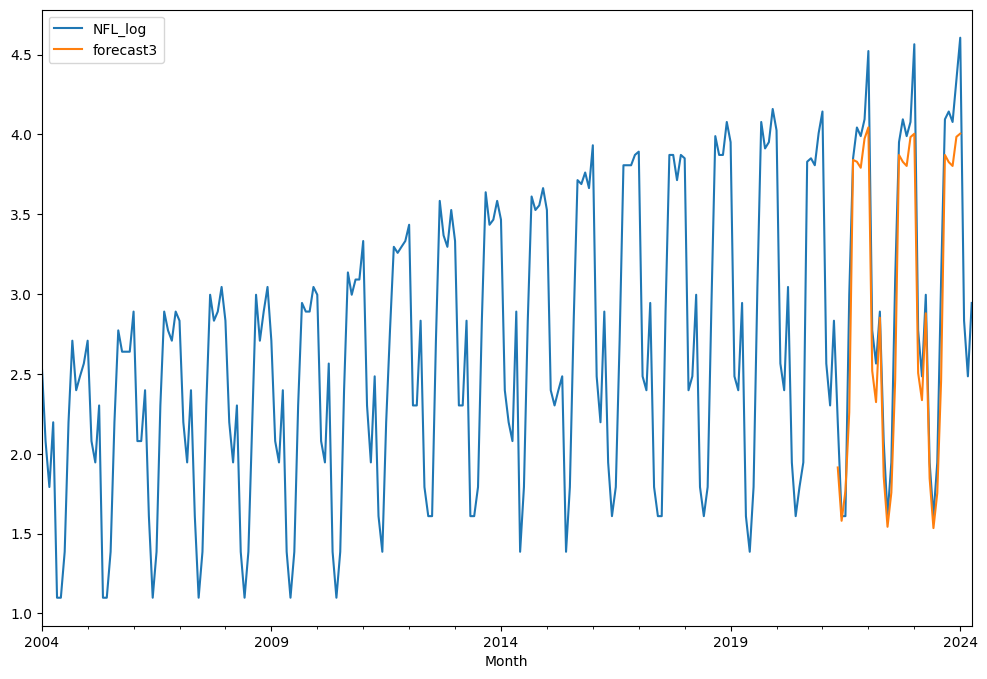

In [ ]:
df['forecast3']=result3.predict(start=208,end=240,dynamic=True)
df[['NFL_log','forecast3']].plot(figsize=(12,8))

In [ ]:
future_dates_=[df_nfl.index[-1]+DateOffset(month=x)for x in range(0,12)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df_nfl.columns)
future_df_nfl=pd.concat([df_nfl,future_dates_df])
future_df_nfl.tail()

NFL: (United States)
2024-07-01                  NaN
2024-08-01                  NaN
2024-09-01                  NaN
2024-10-01                  NaN
2024-11-01                  NaN

In [ ]:
future_df_nfl['forecast']=result3.predict(start=240,end=280,dynamic=True)